In [1]:
#Importing the necessary packages
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from sklearn.linear_model import LinearRegression 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats

Reading the main Covid Dataset

In [2]:
# reading the Covid dataset
covid = pd.read_parquet("../../../data/covid_combined_dataset.parquet.gzip")
covid

countyFIPS      County Name State  StateFIPS       Date  Cases  \
0              1001  Autauga County     AL          1 2020-01-22      0   
1              1001  Autauga County     AL          1 2020-01-23      0   
2              1001  Autauga County     AL          1 2020-01-24      0   
3              1001  Autauga County     AL          1 2020-01-25      0   
4              1001  Autauga County     AL          1 2020-01-26      0   
...             ...              ...   ...        ...        ...    ...   
2381631       56045   Weston County     WY         56 2022-02-13   1524   
2381632       56045   Weston County     WY         56 2022-02-14   1524   
2381633       56045   Weston County     WY         56 2022-02-15   1528   
2381634       56045   Weston County     WY         56 2022-02-16   1528   
2381635       56045   Weston County     WY         56 2022-02-17   1528   

         Death  population  
0            0       55869  
1            0       55869  
2            0       55869  
3            0       55869  
4            0       55869  
...        ...         ...  
2381631     17        6927  
2381632     17        6927  
2381633     17        6927  
2381634     17        6927  
2381635     17        6927  

[2381636 rows x 8 columns]

Taking Washington for Analysis

In [3]:
Wash = covid[covid['State'] == 'WA']

#Grouping by Date with Cases and Deaths
Wash = Wash.groupby('Date')[['Cases','Death']].sum()
Wash = Wash.reset_index()
Wash

Date    Cases  Death
0   2020-01-22        1      0
1   2020-01-23        1      0
2   2020-01-24        1      0
3   2020-01-25        1      0
4   2020-01-26        1      0
..         ...      ...    ...
753 2022-02-13  1407383  11311
754 2022-02-14  1407525  11367
755 2022-02-15  1407525  11367
756 2022-02-16  1407407  11516
757 2022-02-17  1407407  11516

[758 rows x 3 columns]

Date from the first day of infections.

In [4]:
next(x[0] for x in enumerate(list(Wash['Cases'].values)) if x[1] > 0)

0

Computing New Deaths and Cases in washington

In [5]:
#new cases
Wash['New cases'] = Wash['Cases'].diff()
#new Deaths
Wash['New deaths'] = Wash['Death'].diff()
Wash = Wash[1:]
Wash

Date    Cases  Death  New cases  New deaths
1   2020-01-23        1      0        0.0         0.0
2   2020-01-24        1      0        0.0         0.0
3   2020-01-25        1      0        0.0         0.0
4   2020-01-26        1      0        0.0         0.0
5   2020-01-27        1      0        0.0         0.0
..         ...      ...    ...        ...         ...
753 2022-02-13  1407383  11311        0.0         0.0
754 2022-02-14  1407525  11367      142.0        56.0
755 2022-02-15  1407525  11367        0.0         0.0
756 2022-02-16  1407407  11516     -118.0       149.0
757 2022-02-17  1407407  11516        0.0         0.0

[757 rows x 5 columns]

In [6]:
# Removing Negative values from New cases and New deaths
def rem_neg(a):
    if a <= 0:
        return 0
    else:
        return a

In [7]:
Wash['New cases'] = Wash['New cases'].apply(rem_neg)
Wash['New deaths'] = Wash['New deaths'].apply(rem_neg)

Ploting the Data of Washinton State

In [8]:
fig = px.line(Wash, x="Date", y="New cases", title='New Cases in Washington')
fig.show()


In [9]:
fig = px.line(Wash, x="Date", y="New deaths", title='New Deaths in Washington')
fig.show()


Displaying by Days

In [10]:
len_wash = [x for x in range(1,len(Wash)+1)]

In [11]:
Wash['days'] = len_wash
Wash

Date    Cases  Death  New cases  New deaths  days
1   2020-01-23        1      0        0.0         0.0     1
2   2020-01-24        1      0        0.0         0.0     2
3   2020-01-25        1      0        0.0         0.0     3
4   2020-01-26        1      0        0.0         0.0     4
5   2020-01-27        1      0        0.0         0.0     5
..         ...      ...    ...        ...         ...   ...
753 2022-02-13  1407383  11311        0.0         0.0   753
754 2022-02-14  1407525  11367      142.0        56.0   754
755 2022-02-15  1407525  11367        0.0         0.0   755
756 2022-02-16  1407407  11516        0.0       149.0   756
757 2022-02-17  1407407  11516        0.0         0.0   757

[757 rows x 6 columns]

In [12]:
#Cases grouped by Days
fig = px.line(Wash, x="days", y="New cases", title='New Cases in Washington grouped by days')
fig.show()


In [13]:
#Deaths Grouped by days
fig = px.line(Wash, x="days", y="New deaths", title='New Deaths in Washington grouped by Date')
fig.show()


Splitting the Data into Training and Testing for Cases in Washington State

In [14]:
#Train Data
x_train = Wash['days'][:735]
y_train = Wash['New cases'][:735]

#Test Data
x_test = Wash['days'][735:]
y_test = Wash['New cases'][735:]

In [15]:
# Reshaping the Data
x_train = np.array(x_train).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)

x_test = np.array(x_test).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

Performing Linear Regression

In [16]:
#Linear Regression
linr = LinearRegression()
linr.fit(x_train,y_train)

LinearRegression()

In [17]:
linr_predicted = linr.predict(x_test)
linr_predicted

array([[4279.17954735],
       [4286.13027926],
       [4293.08101117],
       [4300.03174308],
       [4306.98247499],
       [4313.93320691],
       [4320.88393882],
       [4327.83467073],
       [4334.78540264],
       [4341.73613455],
       [4348.68686646],
       [4355.63759837],
       [4362.58833028],
       [4369.53906219],
       [4376.48979411],
       [4383.44052602],
       [4390.39125793],
       [4397.34198984],
       [4404.29272175],
       [4411.24345366],
       [4418.19418557],
       [4425.14491748]])

Calculating RMSE for New Cases in Washington

In [18]:
MSE = np.square(np.subtract(x_test,linr_predicted)).mean() 
RMSE = math.sqrt(MSE)
RMSE

3605.859874632877

***Trends for cases in Washington***

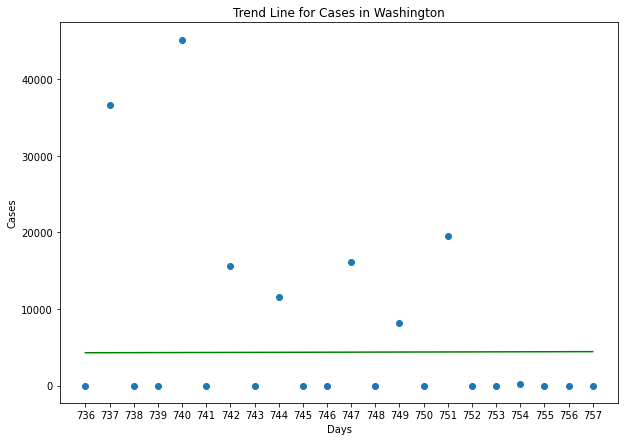

In [19]:
plt.figure(figsize=(10,7))
plt.xticks(x_test)
plt.title('Trend Line for Cases in Washington')

#Labels
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(x_test,y_test)
plt.plot(x_test,linr_predicted, color='green')

***Trend Line for cases in washington***

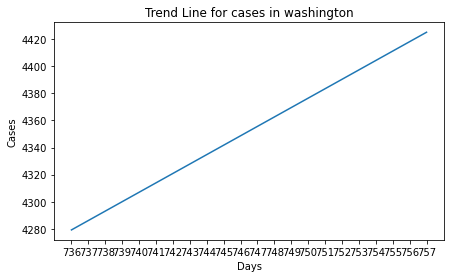

In [20]:
plt.figure(figsize=(7,4))
plt.xticks(x_test)
plt.title('Trend Line for cases in washington')

#labels
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(x_test,linr_predicted)

***Confidence Intervals***

In [21]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [22]:
up = [] #upper value
low = [] #lower value
for i in range(len(x_test)):
    up.append(get_prediction_interval(i,y_test, linr_predicted)[2])
    low.append(get_prediction_interval(i,y_test, linr_predicted)[0])

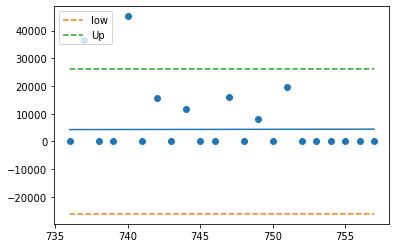

In [23]:
plt.scatter(x_test,y_test)
plt.plot(x_test,linr_predicted)
plt.plot(x_test,low,'--',label='low')
plt.plot(x_test,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

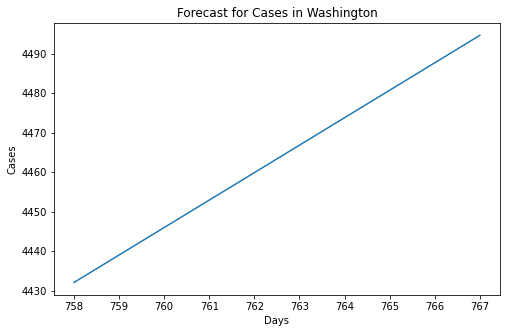

In [24]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for Cases in Washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next,linr.predict(next.reshape(-1, 1)))

Polynomial Regression Model for new cases in washington for degree 2 

In [25]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

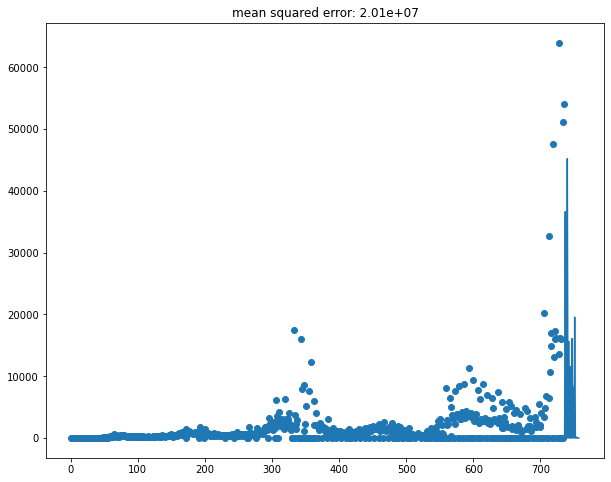

In [26]:
wash_model = PolynomialRegression(2)
wash_model.fit(x_train, y_train)
wash_p2 = wash_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(wash_model.predict(x_train), y_train)));

Calculating RMSE for New Cases with ploynomial degree 2

In [27]:
MSE = np.square(np.subtract(x_test,wash_p2)).mean() 
RMSE = math.sqrt(MSE)
RMSE

5841.074570713927

***Trends for cases in Washington***

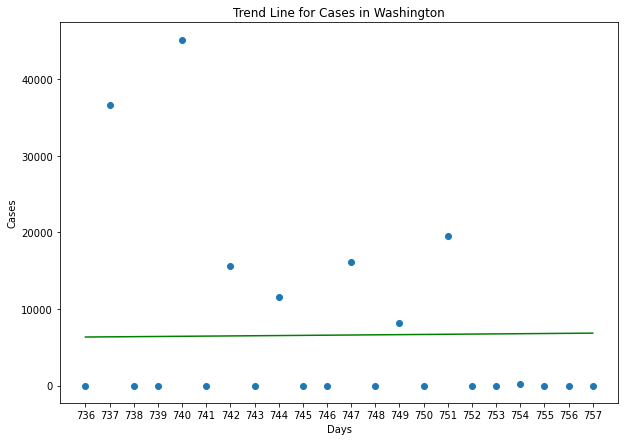

In [28]:
plt.figure(figsize=(10,7))
plt.xticks(x_test)
plt.title('Trend Line for Cases in Washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(x_test,y_test)
plt.plot(x_test,wash_p2, color='green')

***Trend Line for cases in washington***

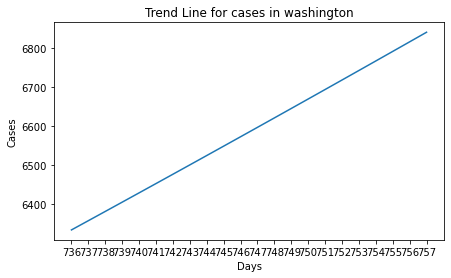

In [29]:
plt.figure(figsize=(7,4))
plt.xticks(x_test)
plt.title('Trend Line for cases in washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(x_test,wash_p2)

***Confidence Intervals***

In [30]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [31]:
up = []
low = []
for i in range(len(x_test)):
    up.append(get_prediction_interval(i,y_test, wash_p2)[2])
    low.append(get_prediction_interval(i,y_test, wash_p2)[0])

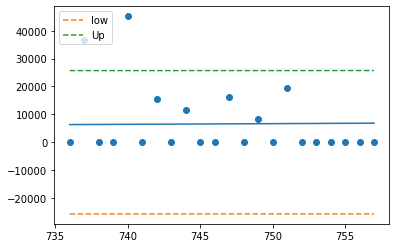

In [32]:
plt.scatter(x_test,y_test)
plt.plot(x_test,wash_p2)
plt.plot(x_test,low,'--',label='low')
plt.plot(x_test,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

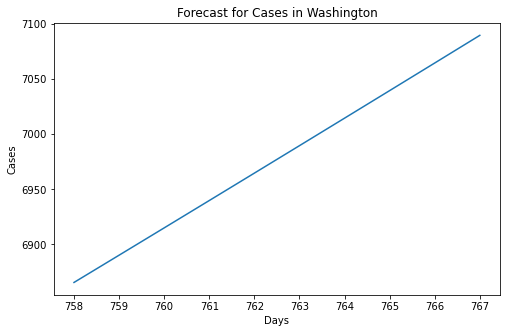

In [33]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for Cases in Washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next, wash_model.predict(next.reshape(-1, 1)))

Polynomial Regression Model for new cases in washington for degree 3

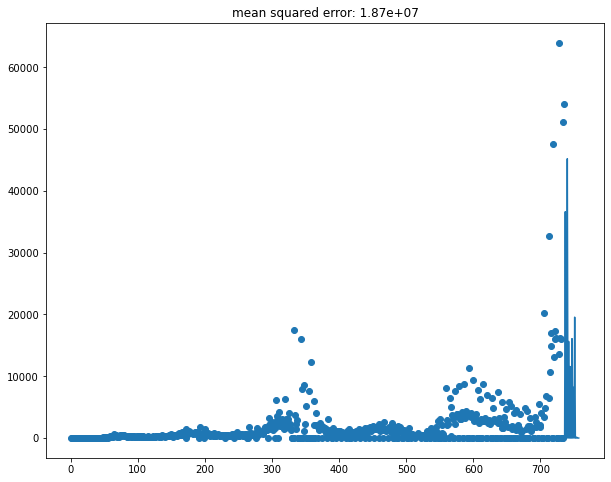

In [34]:
wash_model = PolynomialRegression(3)
wash_model.fit(x_train, y_train)
wash_p3 = wash_model.predict(x_test)

plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(wash_model.predict(x_train), y_train)));

Calculating RMSE for new Cases with ploynomial degree 3

In [35]:
MSE = np.square(np.subtract(x_test,wash_p3)).mean() 
RMSE = math.sqrt(MSE)
RMSE

9480.880990071148

***Trends for cases in Washington***

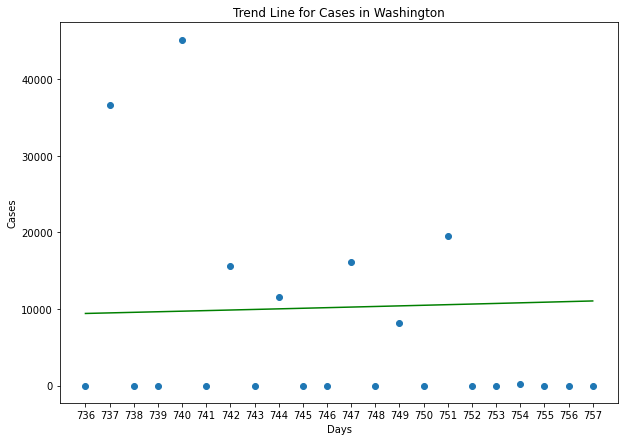

In [36]:
plt.figure(figsize=(10,7))
plt.xticks(x_test)
plt.title('Trend Line for Cases in Washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(x_test,y_test)
plt.plot(x_test,wash_p3, color='green')

***Trend Line for cases in washington***

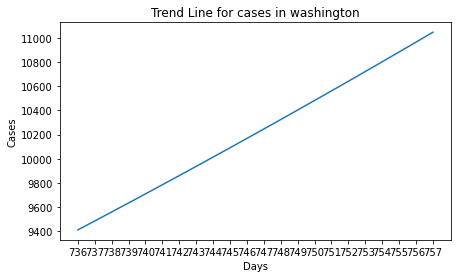

In [37]:
plt.figure(figsize=(7,4))
plt.xticks(x_test)
plt.title('Trend Line for cases in washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(x_test,wash_p3)

***Confidence Interval***

In [38]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
#get interval from standard deviation
    one_minus_pi = 1 - pi
    pf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(pf_lookup)
    interval = z_score * stdev
    
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [39]:
up = []
low = []
for i in range(len(x_test)):
    up.append(get_prediction_interval(i,y_test, wash_p3)[2])
    low.append(get_prediction_interval(i,y_test, wash_p3)[0])

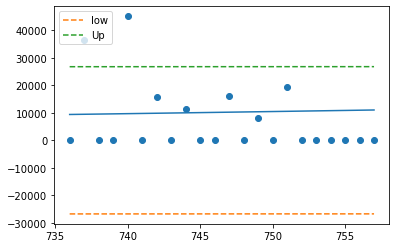

In [40]:
plt.scatter(x_test,y_test)
plt.plot(x_test,wash_p3)
plt.plot(x_test,low,'--',label='low')
plt.plot(x_test,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

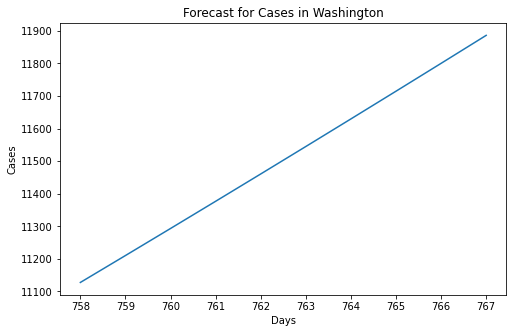

In [41]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for Cases in Washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next, wash_model.predict(next.reshape(-1, 1)))

Splitting the Data into Trainning and Testing for New deaths

In [42]:
# Train data
x_train = Wash['days'][:735]
y_train = Wash['New deaths'][:735]

#Test data
x_test = Wash['days'][735:]
y_test = Wash['New deaths'][735:]

In [43]:
#Reshaping the Data
x_train = np.array(x_train).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)


x_test = np.array(x_test).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

***Linear Regression***

In [44]:
#Linear Regression
linr = LinearRegression()
linr.fit(x_train,y_train)

LinearRegression()

In [45]:
linr_predicted = linr.predict(x_test)
linr_predicted

array([[23.8663738 ],
       [23.8908554 ],
       [23.91533701],
       [23.93981861],
       [23.96430022],
       [23.98878183],
       [24.01326343],
       [24.03774504],
       [24.06222664],
       [24.08670825],
       [24.11118986],
       [24.13567146],
       [24.16015307],
       [24.18463467],
       [24.20911628],
       [24.23359788],
       [24.25807949],
       [24.2825611 ],
       [24.3070427 ],
       [24.33152431],
       [24.35600591],
       [24.38048752]])

Calculating The RMSE for new cases

In [46]:
MSE = np.square(np.subtract(x_test,linr_predicted)).mean() 
RMSE = math.sqrt(MSE)
RMSE

722.4030808960192

***Trends for Deaths in Washington***

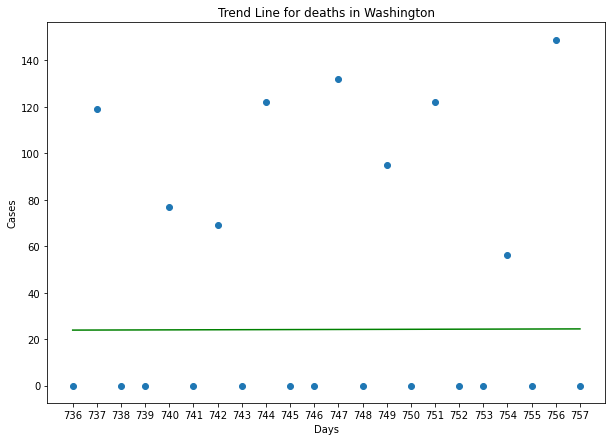

In [47]:
plt.figure(figsize=(10,7))
plt.xticks(x_test)
plt.title('Trend Line for deaths in Washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(x_test,y_test)
plt.plot(x_test,linr_predicted, color='green')

***Trend Line for Deaths in washington***

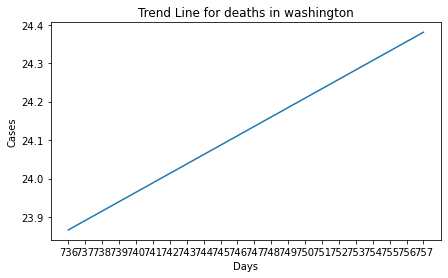

In [48]:
plt.figure(figsize=(7,4))
plt.xticks(x_test)
plt.title('Trend Line for deaths in washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(x_test,linr_predicted)

Confidence Interval

In [49]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [50]:
up = []
low = []
for i in range(len(x_test)):
    up.append(get_prediction_interval(i,y_test, linr_predicted)[2])
    low.append(get_prediction_interval(i,y_test, linr_predicted)[0])

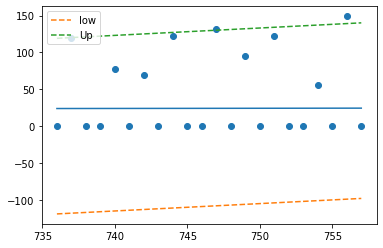

In [51]:
plt.scatter(x_test,y_test)
plt.plot(x_test,linr_predicted)
plt.plot(x_test,low,'--',label='low')
plt.plot(x_test,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

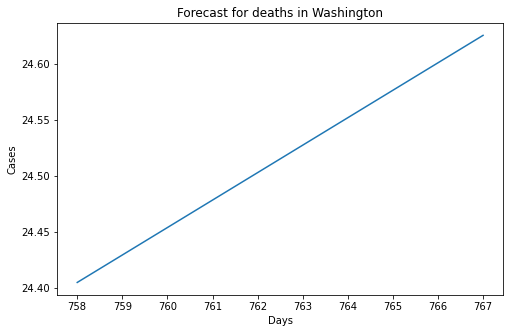

In [52]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for deaths in Washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next, linr.predict(next.reshape(-1, 1)))

Polynomial Regression Model for New Deaths for degree 2

In [53]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

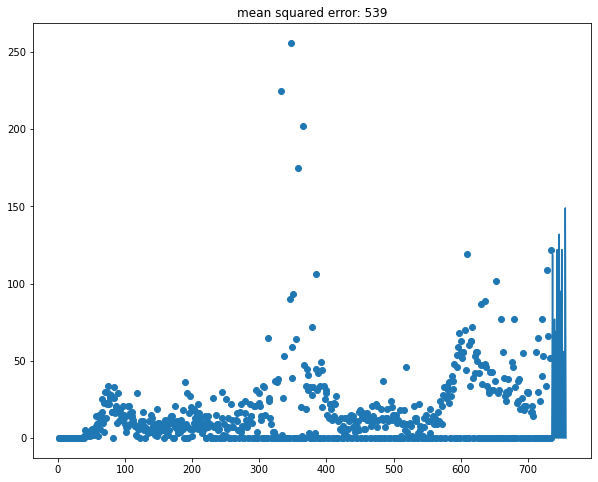

In [54]:
wash_model = PolynomialRegression(2)
wash_model.fit(x_train, y_train)
wash_p2 = wash_model.predict(x_test)

#Plotting MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(wash_model.predict(x_train), y_train)));

Calculating RMSE for ploynomial degree 2

In [55]:
MSE = np.square(np.subtract(x_test,wash_p2)).mean() 
RMSE = math.sqrt(MSE)
RMSE

721.6335171784677

Trends of deaths in washington

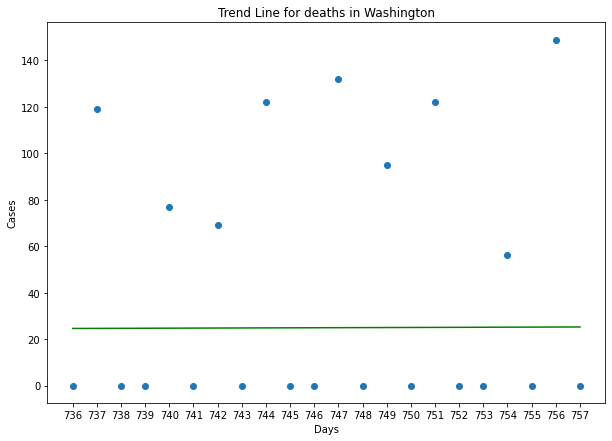

In [56]:
plt.figure(figsize=(10,7))
plt.xticks(x_test)
plt.title('Trend Line for deaths in Washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(x_test,y_test)
plt.plot(x_test,wash_p2, color='green')

***Trend Line for Deaths in washington***

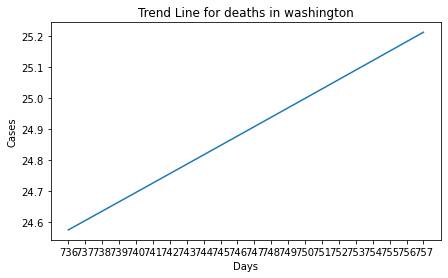

In [57]:
plt.figure(figsize=(7,4))
plt.xticks(x_test)
plt.title('Trend Line for deaths in washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(x_test, wash_p2)

Confidence Interval

In [58]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [59]:
up = []
low = []
for i in range(len(x_test)):
    up.append(get_prediction_interval(i,y_test, wash_p2)[2])
    low.append(get_prediction_interval(i,y_test, wash_p2)[0])

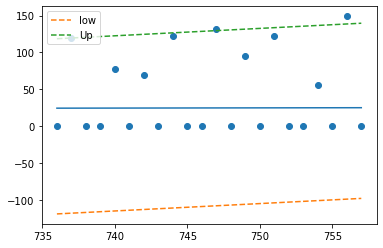

In [60]:
plt.scatter(x_test,y_test)
plt.plot(x_test,wash_p2)
plt.plot(x_test,low,'--',label='low')
plt.plot(x_test,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

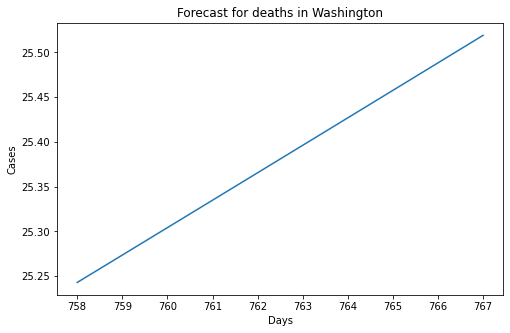

In [61]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for deaths in Washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next, wash_model.predict(next.reshape(-1, 1)))

Polynomial Regression Model for New Deaths for degree 3

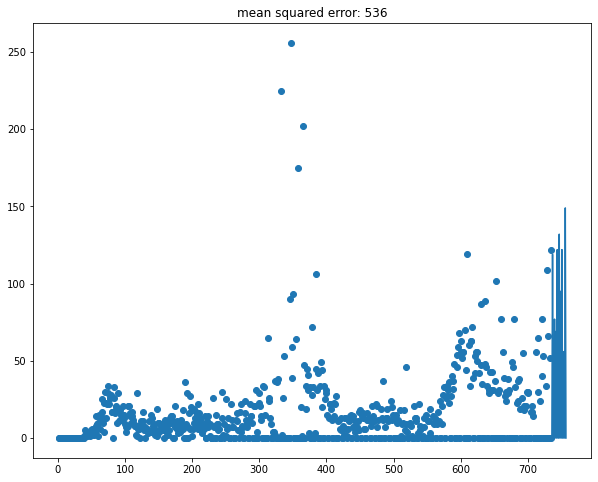

In [62]:
wash_model = PolynomialRegression(3)
wash_model.fit(x_train, y_train)
wash_p2 = wash_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(wash_model.predict(x_train), y_train)));

Calculating RMSE for ploynomial degree 3

In [63]:
MSE = np.square(np.subtract(x_test,wash_p3)).mean() 
RMSE = math.sqrt(MSE)
RMSE

9480.880990071148

Trends of deaths in washington

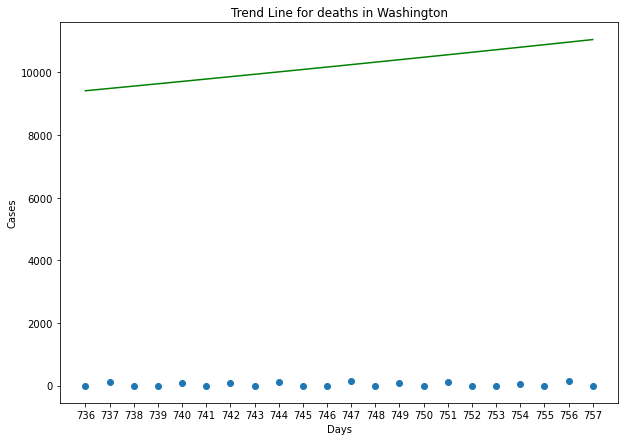

In [64]:
plt.figure(figsize=(10,7))
plt.xticks(x_test)
plt.title('Trend Line for deaths in Washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(x_test,y_test)
plt.plot(x_test,wash_p3, color='green')

***Trend Line for Deaths in washington***

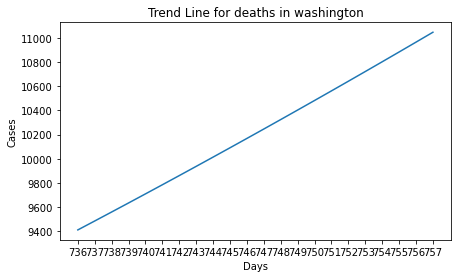

In [65]:
plt.figure(figsize=(7,4))
plt.xticks(x_test)
plt.title('Trend Line for deaths in washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(x_test, wash_p3)

Confidence Interval

In [66]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
#get interval from standard deviation
    one_minus_pi = 1 - pi
    pf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(pf_lookup)
    interval = z_score * stdev
    
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [67]:
up = []
low = []
for i in range(len(x_test)):
    up.append(get_prediction_interval(i,y_test, wash_p3)[2])
    low.append(get_prediction_interval(i,y_test, wash_p3)[0])

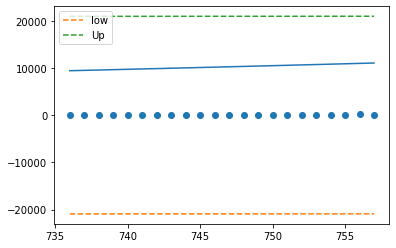

In [68]:
plt.scatter(x_test,y_test)
plt.plot(x_test,wash_p3)
plt.plot(x_test,low,'--',label='low')
plt.plot(x_test,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

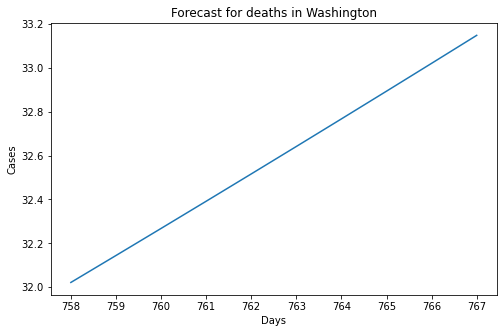

In [69]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for deaths in Washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next, wash_model.predict(next.reshape(-1, 1)))

Counties with High Cases in Washington

In [70]:
#Grouping the Counties in Washington
wash = covid[covid['State'] == 'WA']
Wash_cntys = wash.groupby('County Name')['Cases'].sum()
Wash_cntys = Wash_cntys.reset_index()
Wash_cntys

County Name     Cases
0          Adams County    1253192
1         Asotin County     909443
2         Benton County   10940024
3         Chelan County    4100320
4        Clallam County    1360233
5          Clark County   14664192
6       Columbia County     102553
7        Cowlitz County    4022742
8        Douglas County    2236297
9          Ferry County     231059
10      Franklin County    7583483
11      Garfield County      78458
12         Grant County    5592387
13  Grays Harbor County    2741196
14        Island County    1341453
15     Jefferson County     358187
16          King County   64314675
17        Kitsap County    5582223
18      Kittitas County    1748412
19     Klickitat County     601979
20         Lewis County    3136607
21       Lincoln County     390349
22         Mason County    1891282
23      Okanogan County    1722630
24       Pacific County     585117
25  Pend Oreille County     483375
26        Pierce County   32385511
27      San Juan County     129711
28        Skagit County    3819951
29      Skamania County     241277
30     Snohomish County   24374583
31       Spokane County   25451767
32       Stevens County    1461864
33      Thurston County    6874874
34     Wahkiakum County      84682
35   Walla Walla County    3124166
36       Whatcom County    5762010
37       Whitman County    2241645
38        Yakima County   17479243

Top Infected Counties in Washington

In [71]:
# Sorting the Counties to find the top infected counties in washington
Wash_infect = wash.sort_values('Cases', ascending = False)
Wash_infect.head()

countyFIPS   County Name State  StateFIPS       Date   Cases  Death  \
2251259       53033  King County     WA         53 2022-02-17  361635   2456   
2251258       53033  King County     WA         53 2022-02-16  361635   2456   
2251256       53033  King County     WA         53 2022-02-14  361584   2427   
2251257       53033  King County     WA         53 2022-02-15  361584   2427   
2251253       53033  King County     WA         53 2022-02-11  360956   2417   

         population  
2251259     2252782  
2251258     2252782  
2251256     2252782  
2251257     2252782  
2251253     2252782

Getting the data from the top 5 infected counties

In [72]:
King_cnty = Wash_infect[Wash_infect['County Name']=='King County ']
Pierce_cnty = Wash_infect[Wash_infect['County Name']=='Pierce County ']
Spoke_cnty = Wash_infect[Wash_infect['County Name']=='Spokane County ']
Snoho_cnty = Wash_infect[Wash_infect['County Name']=='Snohomish County ']
Yakima_cnty = Wash_infect[Wash_infect['County Name']=='Yakima County ']

In [73]:
# grouping counties by cases and deaths
king_cnty = King_cnty.groupby('Date')[['Cases','Death']].sum()
pierce_cnty = Pierce_cnty.groupby('Date')[['Cases','Death']].sum()
spoke_cnty = Spoke_cnty.groupby('Date')[['Cases','Death']].sum()
snoho_cnty = Snoho_cnty.groupby('Date')[['Cases','Death']].sum()
yakima_cnty = Yakima_cnty.groupby('Date')[['Cases','Death']].sum()

***King County***

In [74]:
#new cases
king_cnty['New cases'] = king_cnty['Cases'].diff()
#new Deaths
king_cnty['New deaths'] = king_cnty['Death'].diff()
king_cnty = king_cnty[1:]
king_cnty = king_cnty.reset_index()
king_cnty

Date   Cases  Death  New cases  New deaths
0   2020-01-23       1      0        0.0         0.0
1   2020-01-24       1      0        0.0         0.0
2   2020-01-25       1      0        0.0         0.0
3   2020-01-26       1      0        0.0         0.0
4   2020-01-27       1      0        0.0         0.0
..         ...     ...    ...        ...         ...
752 2022-02-13  360956   2417        0.0         0.0
753 2022-02-14  361584   2427      628.0        10.0
754 2022-02-15  361584   2427        0.0         0.0
755 2022-02-16  361635   2456       51.0        29.0
756 2022-02-17  361635   2456        0.0         0.0

[757 rows x 5 columns]

In [75]:
king_cnty['Day_count'] = [x for x in range(1,len(king_cnty)+1)]
king_cnty

Date   Cases  Death  New cases  New deaths  Day_count
0   2020-01-23       1      0        0.0         0.0          1
1   2020-01-24       1      0        0.0         0.0          2
2   2020-01-25       1      0        0.0         0.0          3
3   2020-01-26       1      0        0.0         0.0          4
4   2020-01-27       1      0        0.0         0.0          5
..         ...     ...    ...        ...         ...        ...
752 2022-02-13  360956   2417        0.0         0.0        753
753 2022-02-14  361584   2427      628.0        10.0        754
754 2022-02-15  361584   2427        0.0         0.0        755
755 2022-02-16  361635   2456       51.0        29.0        756
756 2022-02-17  361635   2456        0.0         0.0        757

[757 rows x 6 columns]

Seprating King County Data into Test and Training data

In [76]:
#Training Data
X_train_k = king_cnty['Day_count'][:737]
y_train_k1 = king_cnty['New cases'][:737] #k1 = new cases in king county
y_train_k2 = king_cnty['New deaths'][:737] #k2 = new deaths in king county

#Test Data
X_test_k = king_cnty['Day_count'][737:]
y_test_k1 = king_cnty['New cases'][737:]
y_test_k2 = king_cnty['New deaths'][737:]

In [77]:
# Removing Negative values from New cases and New deaths
def rem_neg(a):
    if a <= 0:
        return 0
    else:
        return a

In [78]:
king_cnty['New cases'] = king_cnty['New cases'].apply(rem_neg)
king_cnty['New deaths'] = king_cnty['New deaths'].apply(rem_neg)

In [79]:
#Reshaping the data
X_train_k = np.array(X_train_k).reshape(-1,1)
y_train_k1 = np.array(y_train_k1).reshape(-1,1)
y_train_k2 = np.array(y_train_k2).reshape(-1,1)

X_test_k = np.array(X_test_k).reshape(-1,1)
y_test_k1 = np.array(y_test_k1).reshape(-1,1)
y_test_k2 = np.array(y_test_k2).reshape(-1,1)

In [80]:
lr = LinearRegression()
lr.fit(X_train_k,y_train_k1)

LinearRegression()

In [81]:
lr_pred_test_k1 = lr.predict(X_test_k)
lr_pred_test_k1

array([[1182.92129152],
       [1184.89126424],
       [1186.86123696],
       [1188.83120968],
       [1190.80118241],
       [1192.77115513],
       [1194.74112785],
       [1196.71110058],
       [1198.6810733 ],
       [1200.65104602],
       [1202.62101874],
       [1204.59099147],
       [1206.56096419],
       [1208.53093691],
       [1210.50090963],
       [1212.47088236],
       [1214.44085508],
       [1216.4108278 ],
       [1218.38080052],
       [1220.35077325]])

Calculating RMSE for King County Cases

In [82]:
mse_king_cases = np.square(np.subtract(y_test_k1, lr_pred_test_k1)).mean()
rmse_king_cases = math.sqrt(mse_king_cases)
rmse_king_cases

2942.802570529011

Trends of cases in king county

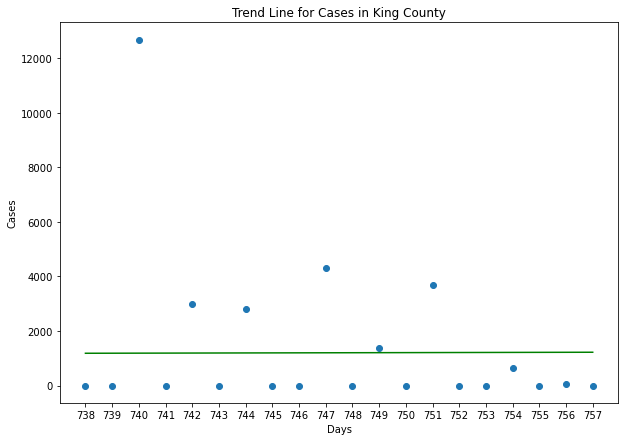

In [83]:
plt.figure(figsize=(10,7))
plt.xticks(x_test)
plt.title('Trend Line for Cases in King County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(X_test_k,y_test_k1)
plt.plot(X_test_k, lr_pred_test_k1, color='green')

***Trend Line for Cases in King County***

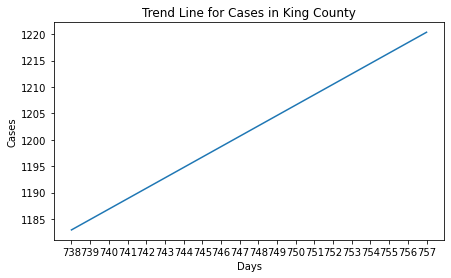

In [84]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_k)
plt.title('Trend Line for Cases in King County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_k, lr_pred_test_k1 )

Confidence Interval

In [85]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [86]:
up = []
low = []
for i in range(len(X_test_k)):
    up.append(get_prediction_interval(i,y_test_k1, lr_pred_test_k1)[2])
    low.append(get_prediction_interval(i,y_test_k1, lr_pred_test_k1)[0])

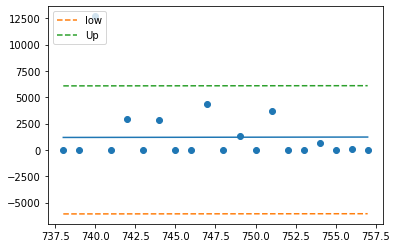

In [87]:
plt.scatter(X_test_k,y_test_k1)
plt.plot(X_test_k,lr_pred_test_k1)
plt.plot(X_test_k,low,'--',label='low')
plt.plot(X_test_k,up,'--',label='Up')
plt.legend(loc='upper left')

***ForeCast***

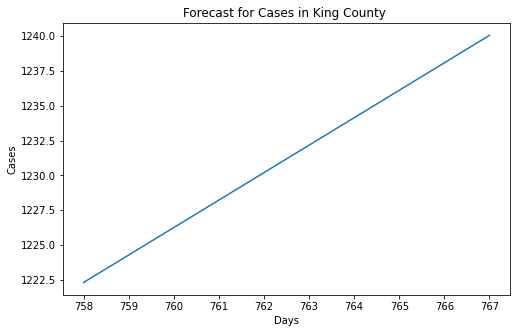

In [88]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for Cases in King County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next, lr.predict(next.reshape(-1, 1)))

Polynomial Regression For new cases in King County with degree 2

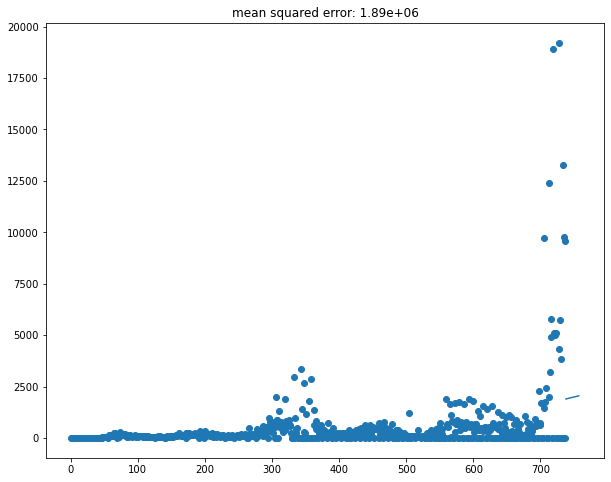

In [89]:
# polynomial regression for degree 2
pl_king_cases = PolynomialRegression(2)
pl_king_cases.fit(X_train_k, y_train_k1)
pred_king = pl_king_cases.predict(X_test_k)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_k.ravel(), y_train_k1)
plt.plot(X_test_k.ravel(),pred_king)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_king_cases.predict(X_train_k), y_train_k1)));


RMSE for new Cases in king county for degree 2

In [90]:
mse_king_casespy = np.square(np.subtract(y_test_k1, pred_king)).mean()
rmse_king_casespy = math.sqrt(mse_king_casespy)
rmse_king_casespy

2995.535292394374

Trends of cases in king county

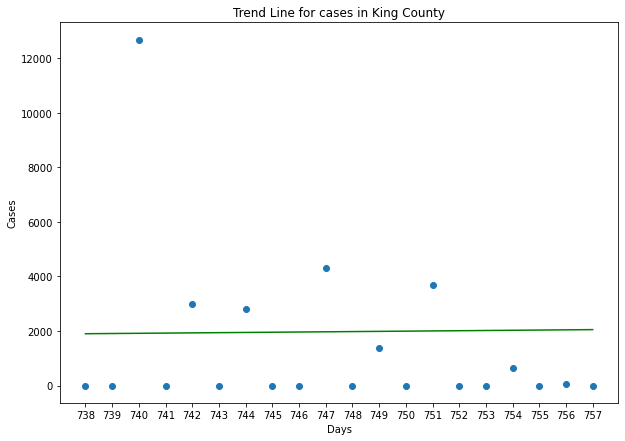

In [91]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_k)
plt.title('Trend Line for cases in King County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(X_test_k,y_test_k1)
plt.plot(X_test_k, pred_king, color='green')

***Trend Line for Cases in King county***

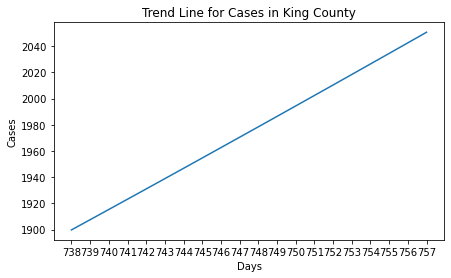

In [92]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_k)
plt.title('Trend Line for Cases in King County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_k, pred_king )

Confidence Interval

In [93]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [94]:
up = []
low = []
for i in range(len(X_test_k)):
    up.append(get_prediction_interval(i,y_test_k1, pred_king)[2])
    low.append(get_prediction_interval(i,y_test_k1, pred_king)[0])

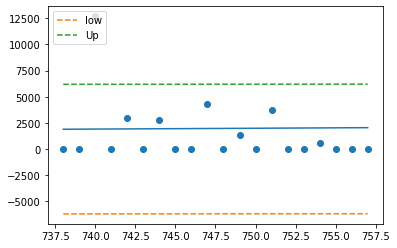

In [95]:
plt.scatter(X_test_k,y_test_k1)
plt.plot(X_test_k,pred_king)
plt.plot(X_test_k,low,'--',label='low')
plt.plot(X_test_k,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

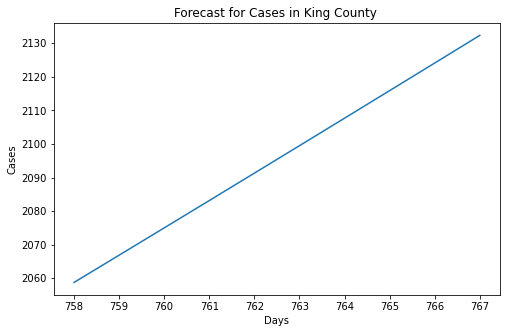

In [96]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for Cases in King County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next, pl_king_cases.predict(next.reshape(-1, 1)))

Polynomial Regression For new cases in King County with degree 3

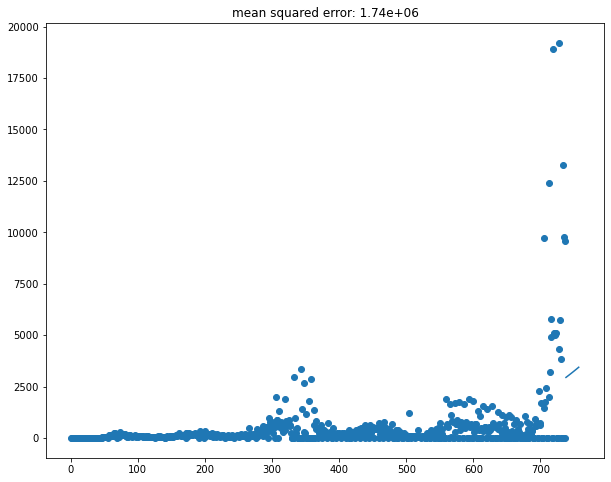

In [97]:
# polynomial regression for degree 3
pl_king_cases = PolynomialRegression(3)
pl_king_cases.fit(X_train_k, y_train_k1)
pred_king = pl_king_cases.predict(X_test_k)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_k.ravel(), y_train_k1)
plt.plot(X_test_k.ravel(),pred_king)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_king_cases.predict(X_train_k), y_train_k1)));

In [98]:
mse_king_casespy = np.square(np.subtract(y_test_k1, pred_king)).mean()
rmse_king_casespy = math.sqrt(mse_king_casespy)
rmse_king_casespy

3462.4750062533485

Trends of cases in king county

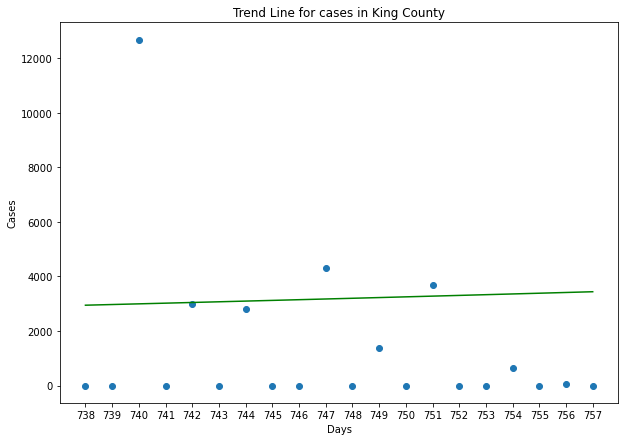

In [99]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_k)
plt.title('Trend Line for cases in King County')

#labels
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(X_test_k,y_test_k1)
plt.plot(X_test_k, pred_king, color='green')

***Trend Line for Cases in King county***

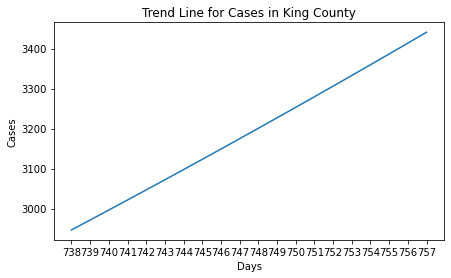

In [100]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_k)
plt.title('Trend Line for Cases in King County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_k, pred_king )

Confidence Interval

In [101]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [102]:
up = []
low = []
for i in range(len(X_test_k)):
    up.append(get_prediction_interval(i,y_test_k1, pred_king)[2])
    low.append(get_prediction_interval(i,y_test_k1, pred_king)[0])

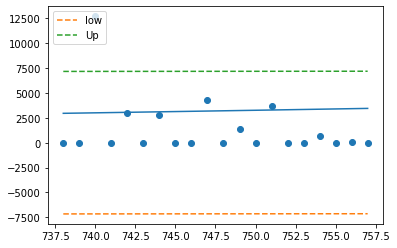

In [103]:
plt.scatter(X_test_k,y_test_k1)
plt.plot(X_test_k,pred_king)
plt.plot(X_test_k,low,'--',label='low')
plt.plot(X_test_k,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

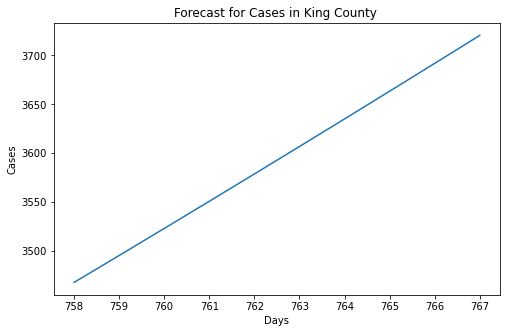

In [104]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for Cases in King County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next, pl_king_cases.predict(next.reshape(-1, 1)))

King County deaths

Linear Regression 

In [105]:
lr = LinearRegression()
lr.fit(X_train_k,y_train_k2)

LinearRegression()

In [106]:
#predicting the data
lr_pred_test_k2 = lr.predict(X_test_k)
lr_pred_test_k2

array([[3.17563492],
       [3.17543063],
       [3.17522634],
       [3.17502205],
       [3.17481776],
       [3.17461347],
       [3.17440918],
       [3.17420489],
       [3.1740006 ],
       [3.17379632],
       [3.17359203],
       [3.17338774],
       [3.17318345],
       [3.17297916],
       [3.17277487],
       [3.17257058],
       [3.17236629],
       [3.172162  ],
       [3.17195771],
       [3.17175342]])

Calculating the MSE for deaths for king county

In [107]:
mse_king_deaths = np.square(np.subtract(y_test_k2, lr_pred_test_k2)).mean()
rmse_king_deaths = math.sqrt(mse_king_deaths)
rmse_king_deaths

12.892926411654352

Trends of deaths in king county

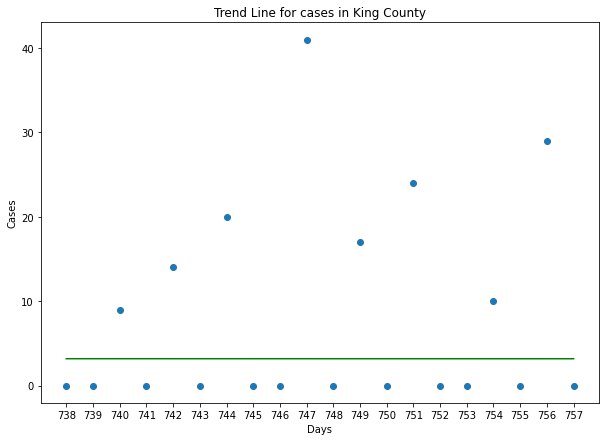

In [108]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_k)
plt.title('Trend Line for cases in King County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(X_test_k,y_test_k2)
plt.plot(X_test_k, lr_pred_test_k2, color='green')

***Trend Line for Cases in King county***

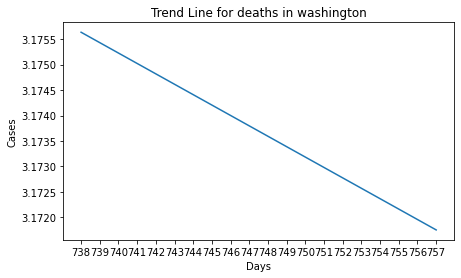

In [109]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_k)
plt.title('Trend Line for deaths in washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_k, lr_pred_test_k2 )

Confidence Interval

In [110]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [111]:
up = []
low = []
for i in range(len(X_test_k)):
    up.append(get_prediction_interval(i,y_test_k2, lr_pred_test_k2)[2])
    low.append(get_prediction_interval(i,y_test_k2, lr_pred_test_k2)[0])

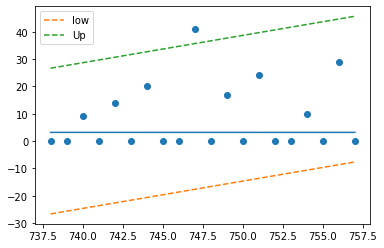

In [112]:
plt.scatter(X_test_k,y_test_k2)
plt.plot(X_test_k,lr_pred_test_k2)
plt.plot(X_test_k,low,'--',label='low')
plt.plot(X_test_k,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

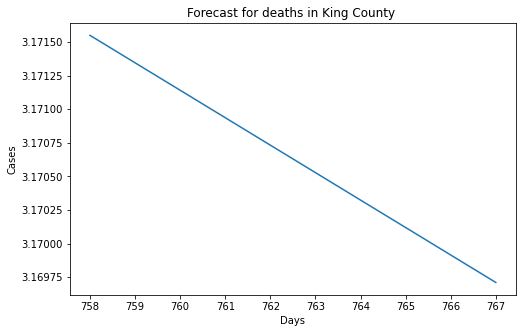

In [113]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for deaths in King County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next,lr.predict(next.reshape(-1, 1)))

Polynomial Regression for new deaths degree 2 

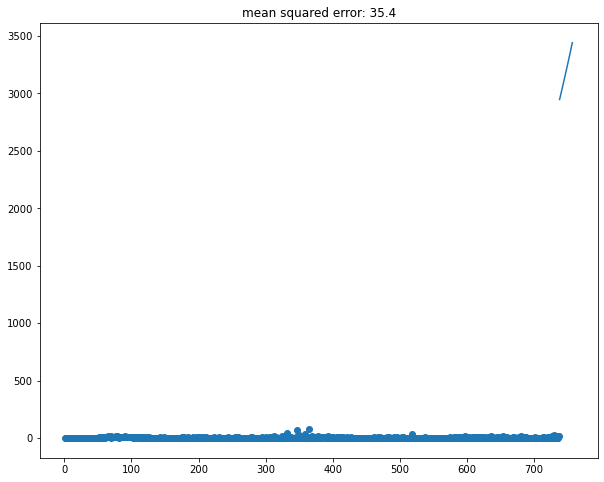

In [114]:
# polynomial regression for degree 2
pl_king_deaths = PolynomialRegression(2)
pl_king_deaths.fit(X_train_k, y_train_k2)
pred_king2 = pl_king_deaths.predict(X_test_k)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_k.ravel(), y_train_k2)
plt.plot(X_test_k.ravel(),pred_king)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_king_deaths.predict(X_train_k), y_train_k2)));


RMSE for deaths in king county with degree 2

In [115]:
mse_king_deathspy = np.square(np.subtract(y_test_k2, pred_king2)).mean()
rmse_king_deathspy = math.sqrt(mse_king_deathspy)
rmse_king_deathspy

12.823386064606826

Trends of deaths in king county

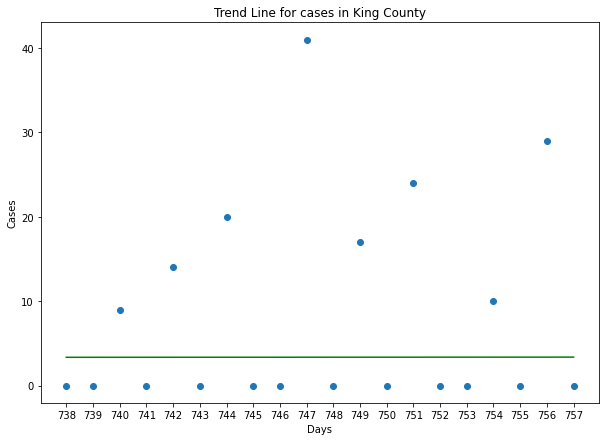

In [116]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_k)
plt.title('Trend Line for cases in King County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(X_test_k,y_test_k2)
plt.plot(X_test_k, pred_king2, color='green')

***Trend Line for Cases in King county***

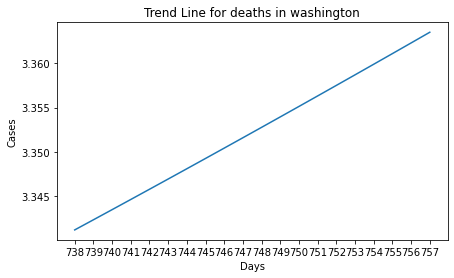

In [117]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_k)
plt.title('Trend Line for deaths in washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_k, pred_king2)

Confidence Interval

In [118]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [119]:
up = []
low = []
for i in range(len(X_test_k)):
    up.append(get_prediction_interval(i,y_test_k2, pred_king2)[2])
    low.append(get_prediction_interval(i,y_test_k2, pred_king2)[0])

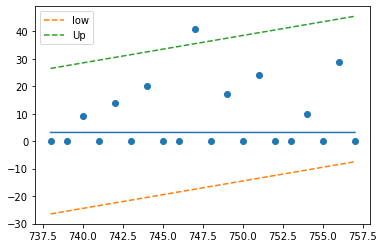

In [120]:
plt.scatter(X_test_k,y_test_k2)
plt.plot(X_test_k,lr_pred_test_k2)
plt.plot(X_test_k,low,'--',label='low')
plt.plot(X_test_k,up,'--',label='Up')
plt.legend(loc='upper left')

***ForeCast***

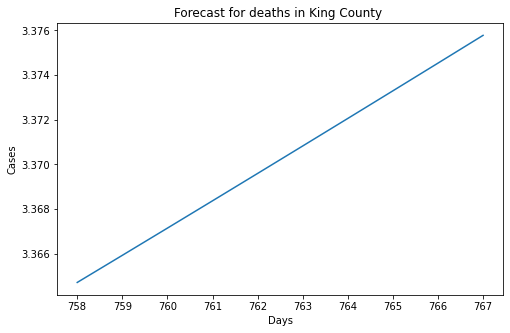

In [121]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for deaths in King County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next,pl_king_deaths.predict(next.reshape(-1, 1)))

Polynomial regression for degree 3

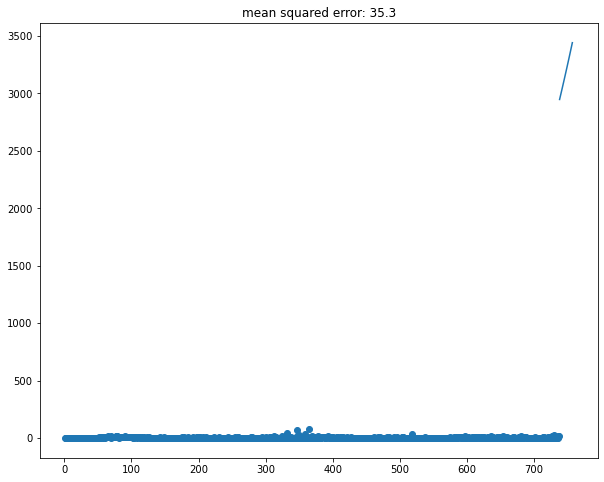

In [122]:
# polynomial regression for degree 3
pl_king_deaths = PolynomialRegression(3)
pl_king_deaths.fit(X_train_k, y_train_k2)
pred_king3 = pl_king_deaths.predict(X_test_k)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_k.ravel(), y_train_k2)
plt.plot(X_test_k.ravel(),pred_king)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_king_deaths.predict(X_train_k), y_train_k2)));

Calculating The RMSE for deaths in king county for degree 3

In [123]:
mse_king_deathspy = np.square(np.subtract(y_test_k2, pred_king3)).mean()
rmse_king_deathspy = math.sqrt(mse_king_deathspy)
rmse_king_deathspy

12.425984584830982

Trends of deaths in king county

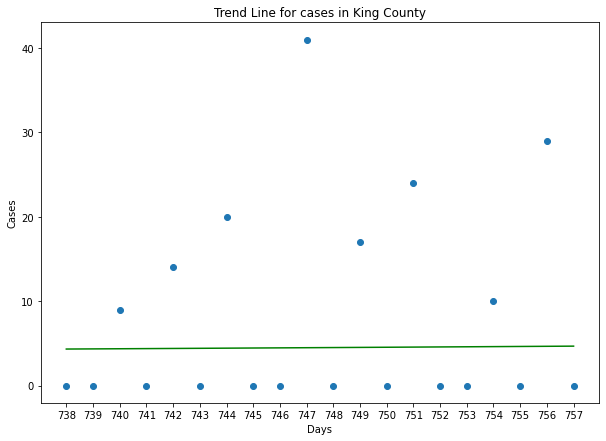

In [124]:
plt.figure(figsize=(10,7))
plt.xticks(X_test_k)
plt.title('Trend Line for cases in King County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.scatter(X_test_k,y_test_k2)
plt.plot(X_test_k, pred_king3, color='green')

***Trend Line for  deaths in King county***

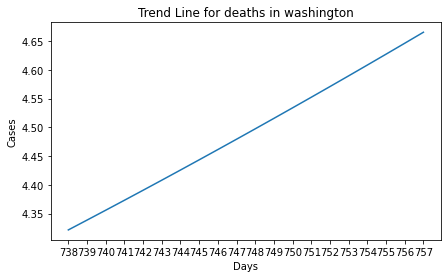

In [125]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_k)
plt.title('Trend Line for deaths in washington')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_k, pred_king3)

Confidence Interval

In [126]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [127]:
up = []
low = []
for i in range(len(X_test_k)):
    up.append(get_prediction_interval(i,y_test_k2, pred_king3)[2])
    low.append(get_prediction_interval(i,y_test_k2, pred_king3)[0])

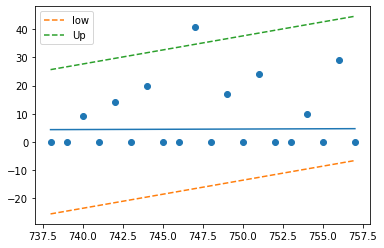

In [128]:
plt.scatter(X_test_k,y_test_k2)
plt.plot(X_test_k,pred_king3)
plt.plot(X_test_k,low,'--',label='low')
plt.plot(X_test_k,up,'--',label='Up')
plt.legend(loc='upper left')

***ForeCast***

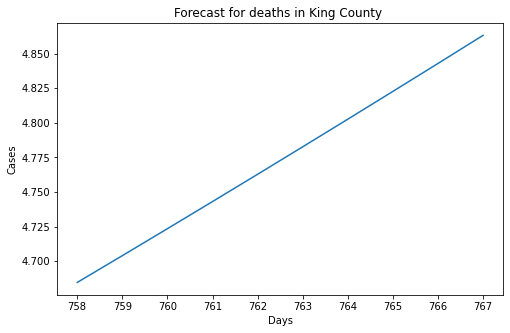

In [129]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for deaths in King County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next,pl_king_deaths.predict(next.reshape(-1, 1)))

***Pierce County***

Inital index of first reported Case

In [130]:
p_cnty = pierce_cnty.reset_index()
p_cnty

Date   Cases  Death
0   2020-01-22       0      0
1   2020-01-23       0      0
2   2020-01-24       0      0
3   2020-01-25       0      0
4   2020-01-26       0      0
..         ...     ...    ...
753 2022-02-13  183707   1230
754 2022-02-14  183497   1242
755 2022-02-15  183497   1242
756 2022-02-16  183301   1261
757 2022-02-17  183301   1261

[758 rows x 3 columns]

In [131]:
c = 1
for i in p_cnty['Cases'].values:
    if i > 0:
        print(c)
        break
    c = c + 1
           

46


In [132]:
pierce_cnty1 = pierce_cnty[45:]

In [133]:
pierce_cnty1

Cases  Death
Date                     
2020-03-07       1      0
2020-03-08       4      0
2020-03-09       4      0
2020-03-10      14      0
2020-03-11      17      0
...            ...    ...
2022-02-13  183707   1230
2022-02-14  183497   1242
2022-02-15  183497   1242
2022-02-16  183301   1261
2022-02-17  183301   1261

[713 rows x 2 columns]

In [134]:
#new cases
pierce_cnty['New cases'] = pierce_cnty['Cases'].diff()
#new Deaths
pierce_cnty['New deaths'] = pierce_cnty['Death'].diff()
pierce_cnty = pierce_cnty.reset_index()
pierce_cnty = pierce_cnty[1:]
pierce_cnty

Date   Cases  Death  New cases  New deaths
1   2020-01-23       0      0        0.0         0.0
2   2020-01-24       0      0        0.0         0.0
3   2020-01-25       0      0        0.0         0.0
4   2020-01-26       0      0        0.0         0.0
5   2020-01-27       0      0        0.0         0.0
..         ...     ...    ...        ...         ...
753 2022-02-13  183707   1230        0.0         0.0
754 2022-02-14  183497   1242     -210.0        12.0
755 2022-02-15  183497   1242        0.0         0.0
756 2022-02-16  183301   1261     -196.0        19.0
757 2022-02-17  183301   1261        0.0         0.0

[757 rows x 5 columns]

In [135]:
# Removing Negative values from New cases and New deaths
def rem_neg(a):
    if a <= 0:
        return 0
    else:
        return a

In [136]:
pierce_cnty['New cases'] = pierce_cnty['New cases'].apply(rem_neg)
pierce_cnty['New deaths'] = pierce_cnty['New deaths'].apply(rem_neg)

In [137]:
#new cases
pierce_cnty1['New cases'] = pierce_cnty1['Cases'].diff()
#new Deaths
pierce_cnty1['New deaths'] = pierce_cnty1['Death'].diff()
pierce_cnty1 = pierce_cnty1[1:]
pierce_cnty = pierce_cnty.reset_index()
pierce_cnty1.head()

Cases  Death  New cases  New deaths
Date                                           
2020-03-08      4      0        3.0         0.0
2020-03-09      4      0        0.0         0.0
2020-03-10     14      0       10.0         0.0
2020-03-11     17      0        3.0         0.0
2020-03-12     17      0        0.0         0.0

In [138]:
pierce_cnty

index       Date   Cases  Death  New cases  New deaths
0        1 2020-01-23       0      0        0.0         0.0
1        2 2020-01-24       0      0        0.0         0.0
2        3 2020-01-25       0      0        0.0         0.0
3        4 2020-01-26       0      0        0.0         0.0
4        5 2020-01-27       0      0        0.0         0.0
..     ...        ...     ...    ...        ...         ...
752    753 2022-02-13  183707   1230        0.0         0.0
753    754 2022-02-14  183497   1242        0.0        12.0
754    755 2022-02-15  183497   1242        0.0         0.0
755    756 2022-02-16  183301   1261        0.0        19.0
756    757 2022-02-17  183301   1261        0.0         0.0

[757 rows x 6 columns]

Calculating Daycount 

In [139]:
pierce_cnty1['Day_count'] = [x for x in range(1,len(pierce_cnty1)+1)]
pierce_cnty1

Cases  Death  New cases  New deaths  Day_count
Date                                                       
2020-03-08       4      0        3.0         0.0          1
2020-03-09       4      0        0.0         0.0          2
2020-03-10      14      0       10.0         0.0          3
2020-03-11      17      0        3.0         0.0          4
2020-03-12      17      0        0.0         0.0          5
...            ...    ...        ...         ...        ...
2022-02-13  183707   1230        0.0         0.0        708
2022-02-14  183497   1242     -210.0        12.0        709
2022-02-15  183497   1242        0.0         0.0        710
2022-02-16  183301   1261     -196.0        19.0        711
2022-02-17  183301   1261        0.0         0.0        712

[712 rows x 5 columns]

Seprating pierce County Data into Test and Training data

In [140]:
#Training Data
X_train_p = pierce_cnty1['Day_count'][:690]
y_train_p1 = pierce_cnty1['New cases'][:690] #k1 = new cases in pierce county
y_train_p2 = pierce_cnty1['New deaths'][:690] #k2 = new deaths in pierce county

#Test Data
X_test_p = pierce_cnty1['Day_count'][690:]
y_test_p1 = pierce_cnty1['New cases'][690:]
y_test_p2 = pierce_cnty1['New deaths'][690:]

In [141]:
#Reshaping the data
X_train_p = np.array(X_train_p).reshape(-1,1)
y_train_p1 = np.array(y_train_p1).reshape(-1,1)
y_train_p2 = np.array(y_train_p2).reshape(-1,1)

X_test_p = np.array(X_test_p).reshape(-1,1)
y_test_p1 = np.array(y_test_p1).reshape(-1,1)
y_test_p2 = np.array(y_test_p2).reshape(-1,1)

In [142]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train_p,y_train_p1)

LinearRegression()

In [143]:
lr_pred_test_p1 = lr.predict(X_test_p)
lr_pred_test_p1

array([[613.26187922],
       [614.33479475],
       [615.40771027],
       [616.4806258 ],
       [617.55354132],
       [618.62645685],
       [619.69937237],
       [620.7722879 ],
       [621.84520342],
       [622.91811895],
       [623.99103447],
       [625.06395   ],
       [626.13686552],
       [627.20978105],
       [628.28269657],
       [629.3556121 ],
       [630.42852763],
       [631.50144315],
       [632.57435868],
       [633.6472742 ],
       [634.72018973],
       [635.79310525]])

MSE for Pierce County with Linear Regression

In [144]:
mse_pierce_cases = np.square(np.subtract(y_test_p1, lr_pred_test_p1)).mean()
rmse_pierce_cases = math.sqrt(mse_pierce_cases)
rmse_pierce_cases

1280.8162015058917

###### we are plotting the trends of the model which has least RMSE values

***Trend Line for Cases in pierce county***

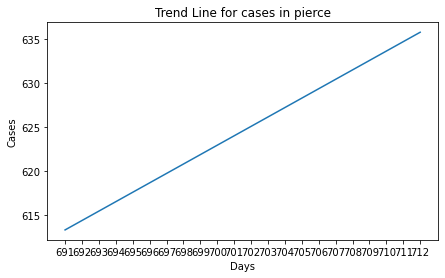

In [145]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_p)
plt.title('Trend Line for cases in pierce')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_p, lr_pred_test_p1 )

Confidence Interval

In [146]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [147]:
up = []
low = []
for i in range(len(X_test_p)):
    up.append(get_prediction_interval(i,y_test_p1, lr_pred_test_p1)[2])
    low.append(get_prediction_interval(i,y_test_p1, lr_pred_test_p1)[0])

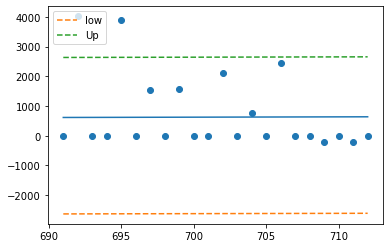

In [148]:
plt.scatter(X_test_p,y_test_p1)
plt.plot(X_test_p,lr_pred_test_p1)
plt.plot(X_test_p,low,'--',label='low')
plt.plot(X_test_p,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

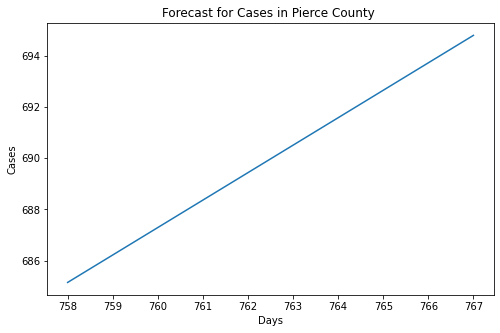

In [149]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for Cases in Pierce County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next,lr.predict(next.reshape(-1, 1)))

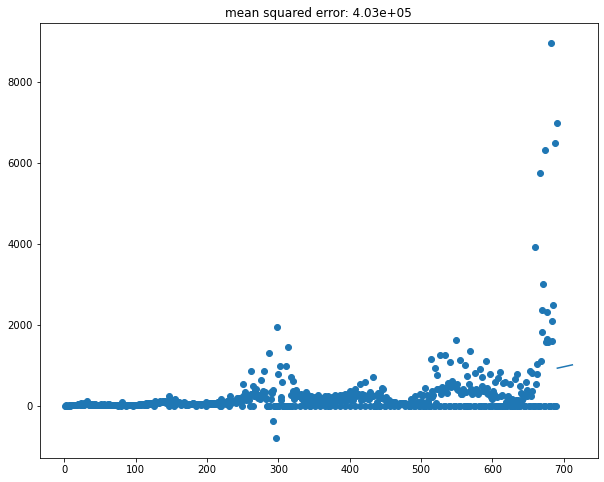

In [150]:
# polynomial regression for degree 2
pl_pierce_cases = PolynomialRegression(2)
pl_pierce_cases.fit(X_train_p, y_train_p1)
pred_pierce = pl_pierce_cases.predict(X_test_p)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_p.ravel(), y_train_p1)
plt.plot(X_test_p.ravel(),pred_pierce)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_pierce_cases.predict(X_train_p), y_train_p1)));

RMSE for pierce county

In [151]:
#mse and rmse for degree 2
mse_pierce_casespy = np.square(np.subtract(y_test_p1, pred_pierce)).mean()
rmse_pierce_casespy = math.sqrt(mse_pierce_casespy)
rmse_pierce_casespy

1306.5192184472862

Polynomial Regression for pierce county

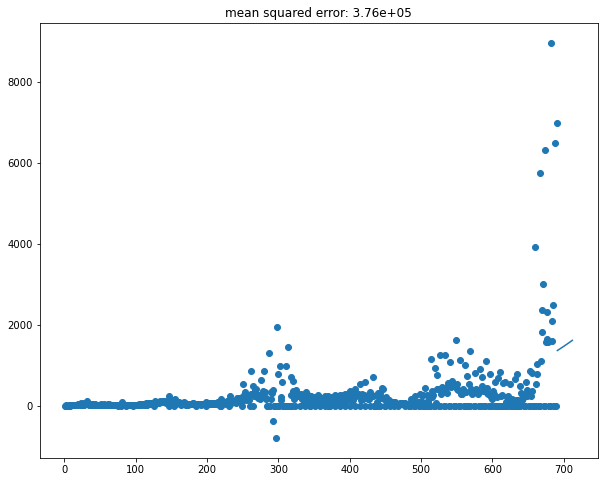

In [152]:
# polynomial regression for degree 3
pl_pierce_cases1 = PolynomialRegression(3)
pl_pierce_cases1.fit(X_train_p, y_train_p1)
pred_pierce1 = pl_pierce_cases1.predict(X_test_p)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_p.ravel(), y_train_p1)
plt.plot(X_test_p.ravel(),pred_pierce1)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_pierce_cases1.predict(X_train_p), y_train_p1)));


In [153]:
#mse and rmse for degree 3
mse_pierce_casespy = np.square(np.subtract(y_test_p1, pred_pierce1)).mean()
rmse_pierce_casespy = math.sqrt(mse_pierce_casespy)
rmse_pierce_casespy

1510.5778248017095

In [154]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train_p,y_train_p2)

LinearRegression()

In [155]:
lr_pred_test_p2 = lr.predict(X_test_p)
lr_pred_test_p2

array([[2.44646095],
       [2.44883121],
       [2.45120147],
       [2.45357173],
       [2.45594199],
       [2.45831225],
       [2.46068251],
       [2.46305277],
       [2.46542303],
       [2.46779329],
       [2.47016355],
       [2.47253381],
       [2.47490407],
       [2.47727433],
       [2.47964458],
       [2.48201484],
       [2.4843851 ],
       [2.48675536],
       [2.48912562],
       [2.49149588],
       [2.49386614],
       [2.4962364 ]])

In [156]:
mse_pierce_deathslr = np.square(np.subtract(y_test_p2, lr_pred_test_p2)).mean()
rmse_pierce_deathslr = math.sqrt(mse_pierce_deathslr)
rmse_pierce_deathslr

8.79134724421058

new deaths in Pierce county with degree 2 polynomial regression

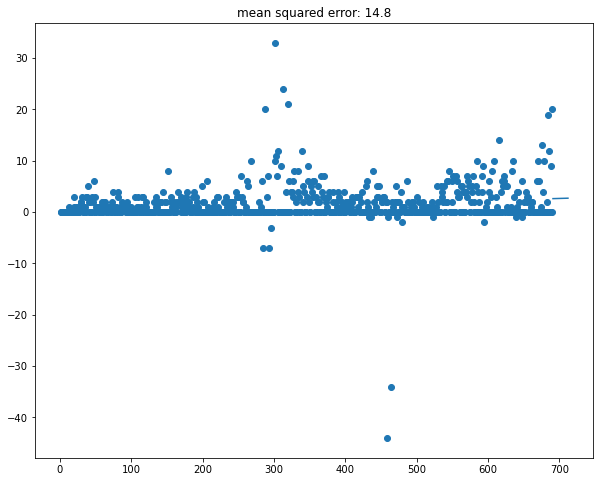

In [157]:
# polynomial regression for degree 2
pl_pierce_cases = PolynomialRegression(2)
pl_pierce_cases.fit(X_train_p, y_train_p2)
pred_pierce1 = pl_pierce_cases.predict(X_test_p)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_p.ravel(), y_train_p2)
plt.plot(X_test_p.ravel(),pred_pierce1)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_pierce_cases.predict(X_train_p), y_train_p2)));

In [158]:
#mse and rmse for degree 2
mse_pierce_deathspy = np.square(np.subtract(y_test_p2, pred_pierce1)).mean()
rmse_pierce_deathspy = math.sqrt(mse_pierce_deathspy)
rmse_pierce_deathspy

8.707160170568583

Text(0.5, 1.0, 'mean squared error: 14.6')

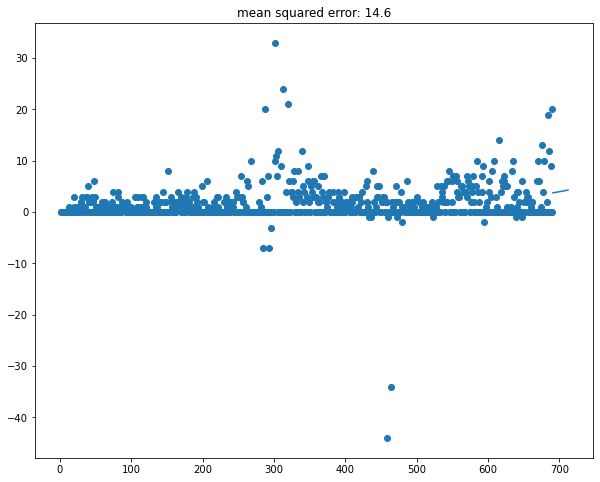

In [159]:
# polynomial regression for degree 3 (new deaths)
pl_pierce_deaths1 = PolynomialRegression(3)
pl_pierce_deaths1.fit(X_train_p, y_train_p2)
pred_pierce1 = pl_pierce_deaths1.predict(X_test_p)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_p.ravel(), y_train_p2)
plt.plot(X_test_p.ravel(),pred_pierce1)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_pierce_deaths1.predict(X_train_p), y_train_p2)))

In [160]:
#mse and rmse for degree 3
mse_pierce_deathspy = np.square(np.subtract(y_test_p2, pred_pierce1)).mean()
rmse_pierce_deathspy = math.sqrt(mse_pierce_deathspy)
rmse_pierce_deathspy

8.243462823692225

***Trend Line for Cases in Pierce county***

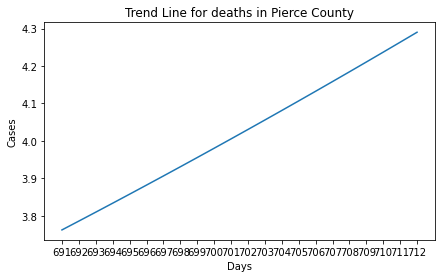

In [161]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_p)
plt.title('Trend Line for deaths in Pierce County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_p, pred_pierce1)

Confidence Interval

In [162]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [163]:
up = []
low = []
for i in range(len(X_test_p)):
    up.append(get_prediction_interval(i,y_test_p2, pred_pierce1)[2])
    low.append(get_prediction_interval(i,y_test_p2, pred_pierce1)[0])

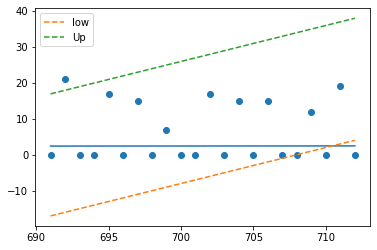

In [164]:
plt.scatter(X_test_p,y_test_p2)
plt.plot(X_test_p,lr_pred_test_p2)
plt.plot(X_test_p,low,'--',label='low')
plt.plot(X_test_p,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

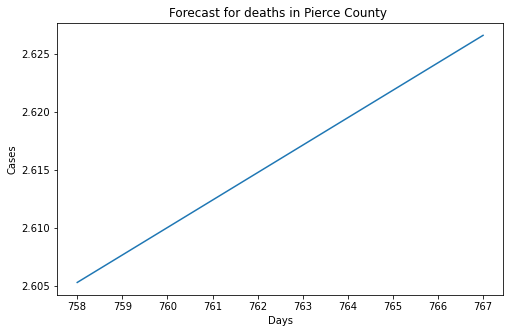

In [165]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for deaths in Pierce County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next,lr.predict(next.reshape(-1, 1)))

***Spoke County***

In [166]:
#new cases
spoke_cnty['New cases'] = spoke_cnty['Cases'].diff()
#new Deaths
spoke_cnty['New deaths'] = spoke_cnty['Death'].diff()
spoke_cnty = spoke_cnty[1:]
spoke_cnty = spoke_cnty.reset_index()
spoke_cnty

Date   Cases  Death  New cases  New deaths
0   2020-01-23       0      0        0.0         0.0
1   2020-01-24       0      0        0.0         0.0
2   2020-01-25       0      0        0.0         0.0
3   2020-01-26       0      0        0.0         0.0
4   2020-01-27       0      0        0.0         0.0
..         ...     ...    ...        ...         ...
752 2022-02-13  120576   1258        0.0         0.0
753 2022-02-14  120772   1262      196.0         4.0
754 2022-02-15  120772   1262        0.0         0.0
755 2022-02-16  120454   1279     -318.0        17.0
756 2022-02-17  120454   1279        0.0         0.0

[757 rows x 5 columns]

In [167]:
s_cnty = spoke_cnty.reset_index()
s_cnty

index       Date   Cases  Death  New cases  New deaths
0        0 2020-01-23       0      0        0.0         0.0
1        1 2020-01-24       0      0        0.0         0.0
2        2 2020-01-25       0      0        0.0         0.0
3        3 2020-01-26       0      0        0.0         0.0
4        4 2020-01-27       0      0        0.0         0.0
..     ...        ...     ...    ...        ...         ...
752    752 2022-02-13  120576   1258        0.0         0.0
753    753 2022-02-14  120772   1262      196.0         4.0
754    754 2022-02-15  120772   1262        0.0         0.0
755    755 2022-02-16  120454   1279     -318.0        17.0
756    756 2022-02-17  120454   1279        0.0         0.0

[757 rows x 6 columns]

In [168]:
# For figuiring the index of which the first case reported
c = 1
for i in s_cnty['Cases'].values:
    if i > 0:
        print(c)
        break
    c = c + 1
           

52


In [169]:
spoke_cnty1 = spoke_cnty[52:]
spoke_cnty1

Date   Cases  Death  New cases  New deaths
52  2020-03-15       3      0        0.0         0.0
53  2020-03-16       3      0        0.0         0.0
54  2020-03-17       4      0        1.0         0.0
55  2020-03-18       4      0        0.0         0.0
56  2020-03-19       9      0        5.0         0.0
..         ...     ...    ...        ...         ...
752 2022-02-13  120576   1258        0.0         0.0
753 2022-02-14  120772   1262      196.0         4.0
754 2022-02-15  120772   1262        0.0         0.0
755 2022-02-16  120454   1279     -318.0        17.0
756 2022-02-17  120454   1279        0.0         0.0

[705 rows x 5 columns]

In [170]:
#new cases
spoke_cnty1['New cases'] = spoke_cnty1['Cases'].diff()
#new Deaths
spoke_cnty1['New deaths'] = spoke_cnty1['Death'].diff()
spoke_cnty1 = spoke_cnty1[1:]
spoke_cnty1.head()

Date  Cases  Death  New cases  New deaths
53 2020-03-16      3      0        0.0         0.0
54 2020-03-17      4      0        1.0         0.0
55 2020-03-18      4      0        0.0         0.0
56 2020-03-19      9      0        5.0         0.0
57 2020-03-20     11      0        2.0         0.0

In [171]:
# Removing Negative values from New cases and New deaths
def rem_neg(a):
    if a <= 0:
        return 0
    else:
        return a

In [172]:
spoke_cnty1['New cases'] = spoke_cnty1['New cases'].apply(rem_neg)
spoke_cnty1['New deaths'] = spoke_cnty1['New deaths'].apply(rem_neg)

In [173]:
spoke_cnty1['Day_count'] = [x for x in range(1,len(spoke_cnty1)+1)]
spoke_cnty1

Date   Cases  Death  New cases  New deaths  Day_count
53  2020-03-16       3      0        0.0         0.0          1
54  2020-03-17       4      0        1.0         0.0          2
55  2020-03-18       4      0        0.0         0.0          3
56  2020-03-19       9      0        5.0         0.0          4
57  2020-03-20      11      0        2.0         0.0          5
..         ...     ...    ...        ...         ...        ...
752 2022-02-13  120576   1258        0.0         0.0        700
753 2022-02-14  120772   1262      196.0         4.0        701
754 2022-02-15  120772   1262        0.0         0.0        702
755 2022-02-16  120454   1279        0.0        17.0        703
756 2022-02-17  120454   1279        0.0         0.0        704

[704 rows x 6 columns]

Sepreating as Trainning and Testing data

In [174]:
#Training Data
X_train_s = spoke_cnty1['Day_count'][:670]
y_train_s1 = spoke_cnty1['New cases'][:670] #s1 = new cases in pierce county
y_train_s2 = spoke_cnty1['New deaths'][:670] #s2 = new deaths in pierce county

#Test Data
X_test_s = spoke_cnty1['Day_count'][670:]
y_test_s1 = spoke_cnty1['New cases'][670:]
y_test_s2 = spoke_cnty1['New deaths'][670:]

In [175]:
#Reshaping the data
X_train_s = np.array(X_train_s).reshape(-1,1)
y_train_s1 = np.array(y_train_s1).reshape(-1,1)
y_train_s2 = np.array(y_train_s2).reshape(-1,1)

X_test_s = np.array(X_test_s).reshape(-1,1)
y_test_s1 = np.array(y_test_s1).reshape(-1,1)
y_test_s2 = np.array(y_test_s2).reshape(-1,1)

In [176]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train_s,y_train_s1)

LinearRegression()

In [177]:
lr_pred_test_s1 = lr.predict(X_test_s)
lr_pred_test_s1

array([[251.01240881],
       [251.35404332],
       [251.69567783],
       [252.03731235],
       [252.37894686],
       [252.72058137],
       [253.06221588],
       [253.4038504 ],
       [253.74548491],
       [254.08711942],
       [254.42875393],
       [254.77038845],
       [255.11202296],
       [255.45365747],
       [255.79529198],
       [256.1369265 ],
       [256.47856101],
       [256.82019552],
       [257.16183003],
       [257.50346455],
       [257.84509906],
       [258.18673357],
       [258.52836808],
       [258.8700026 ],
       [259.21163711],
       [259.55327162],
       [259.89490613],
       [260.23654065],
       [260.57817516],
       [260.91980967],
       [261.26144418],
       [261.6030787 ],
       [261.94471321],
       [262.28634772]])

Calculating RMSE for Spoke County Cases

In [178]:
mse_spoke_cases = np.square(np.subtract(y_test_s1, lr_pred_test_s1)).mean()
rmse_spoke_cases = math.sqrt(mse_spoke_cases)
rmse_spoke_cases

1659.4091795154468

Polynomial Regression For new cases in Spoke County with degree 2

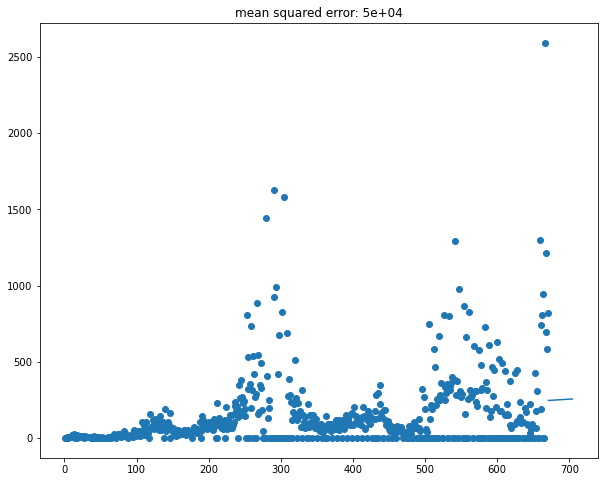

In [179]:
# polynomial regression for degree 2
pl_spoke_cases = PolynomialRegression(2)
pl_spoke_cases.fit(X_train_s, y_train_s1)
pred_spoke = pl_spoke_cases.predict(X_test_s)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_s.ravel(), y_train_s1)
plt.plot(X_test_s.ravel(),pred_spoke)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_spoke_cases.predict(X_train_s), y_train_s1)));


RMSE for new Cases in spoke county for degree 2

In [180]:
mse_spoke_casespy = np.square(np.subtract(y_test_s1, pred_spoke)).mean()
rmse_spoke_casespy = math.sqrt(mse_spoke_casespy)
rmse_spoke_casespy

1661.3828546885454

Polynomial Regression For new cases in spoke County with degree 3

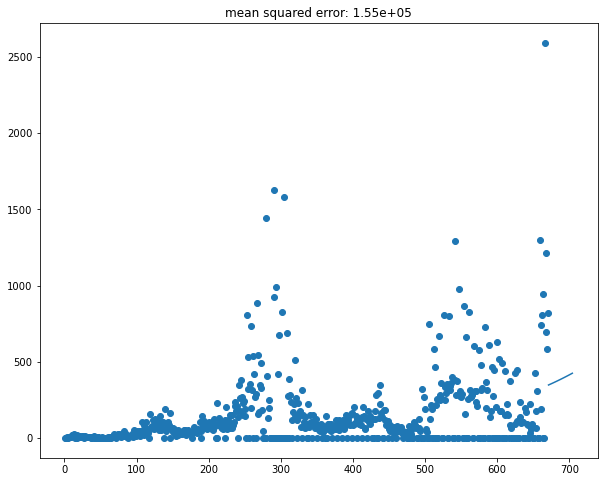

In [181]:
# polynomial regression for degree 3
pl_spoke_cases = PolynomialRegression(3)
pl_spoke_cases.fit(X_train_s, y_train_s1)
pred_spoke = pl_spoke_cases.predict(X_test_s)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_s.ravel(), y_train_s1)
plt.plot(X_test_s.ravel(),pred_spoke)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_king_cases.predict(X_train_s), y_train_s1)));

In [182]:
mse_spoke_casespy = np.square(np.subtract(y_test_s1, pred_spoke)).mean()
rmse_spoke_casespy = math.sqrt(mse_spoke_casespy)
rmse_spoke_casespy

1619.5297049578662

***Trend Line for Cases in Spoke county***

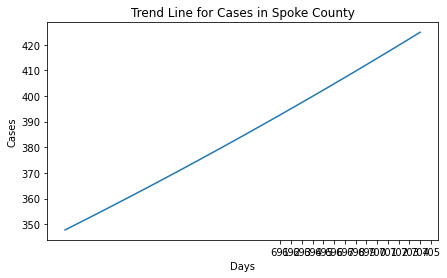

In [183]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_p)
plt.title('Trend Line for Cases in Spoke County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_s, pred_spoke)

Confidence Interval

In [184]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [185]:
up = []
low = []
for i in range(len(X_test_s)):
    up.append(get_prediction_interval(i,y_test_s1, pred_spoke)[2])
    low.append(get_prediction_interval(i,y_test_s1, pred_spoke)[0])

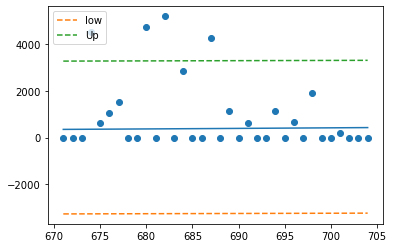

In [186]:
plt.scatter(X_test_s,y_test_s1)
plt.plot(X_test_s,pred_spoke)
plt.plot(X_test_s,low,'--',label='low')
plt.plot(X_test_s,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

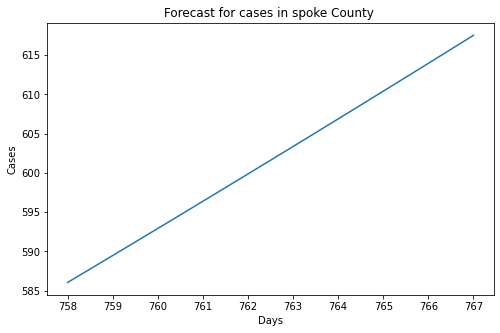

In [187]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for cases in spoke County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next,pl_spoke_cases.predict(next.reshape(-1, 1)))

Linear regression for deaths

In [188]:
lr = LinearRegression()
lr.fit(X_train_s,y_train_s1)

LinearRegression()

Calculating the RMSE for deaths

In [189]:
lr_pred_test_s1 = lr.predict(X_test_s)
lr_pred_test_s1

array([[251.01240881],
       [251.35404332],
       [251.69567783],
       [252.03731235],
       [252.37894686],
       [252.72058137],
       [253.06221588],
       [253.4038504 ],
       [253.74548491],
       [254.08711942],
       [254.42875393],
       [254.77038845],
       [255.11202296],
       [255.45365747],
       [255.79529198],
       [256.1369265 ],
       [256.47856101],
       [256.82019552],
       [257.16183003],
       [257.50346455],
       [257.84509906],
       [258.18673357],
       [258.52836808],
       [258.8700026 ],
       [259.21163711],
       [259.55327162],
       [259.89490613],
       [260.23654065],
       [260.57817516],
       [260.91980967],
       [261.26144418],
       [261.6030787 ],
       [261.94471321],
       [262.28634772]])

In [190]:
mse_spoke_deaths = np.square(np.subtract(y_test_s2, lr_pred_test_s1)).mean()
rmse_spoke_deaths = math.sqrt(mse_spoke_deaths)
rmse_spoke_deaths

253.52591615740647

Polynomial Regression for degree 2 (New Deaths)

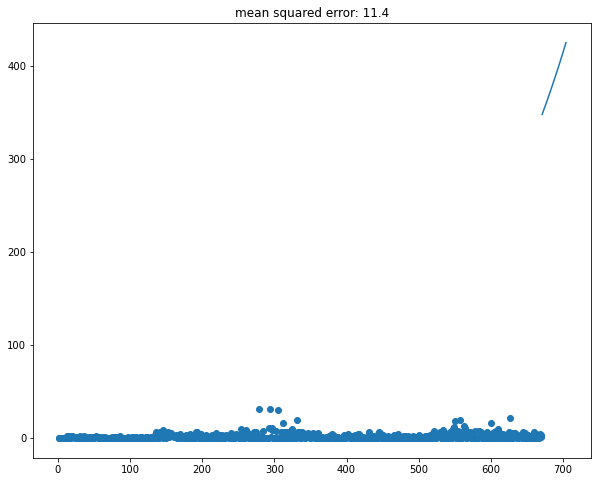

In [191]:
# polynomial regression for degree 2
pl_spoke_deaths = PolynomialRegression(2)
pl_spoke_deaths.fit(X_train_s, y_train_s2)
pred_spoke2 = pl_king_deaths.predict(X_test_s)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_s.ravel(), y_train_s2)
plt.plot(X_test_s.ravel(),pred_spoke)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_spoke_deaths.predict(X_train_s), y_train_s2)));


RMSE for deaths in spoke county with degree 2

In [192]:
mse_spoke_deathspy = np.square(np.subtract(y_test_s2, pred_spoke2)).mean()
rmse_spoke_deathspy = math.sqrt(mse_spoke_deathspy)
rmse_spoke_deathspy

4.672586231385682

Polynomial regression for degree 3

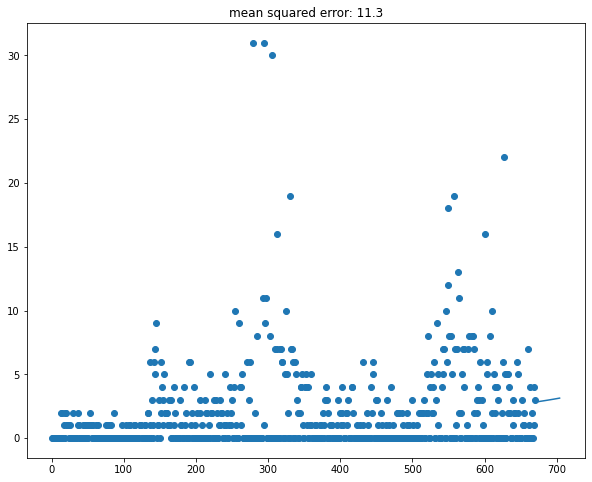

In [193]:
# polynomial regression for degree 3
pl_spoke_deaths = PolynomialRegression(3)
pl_spoke_deaths.fit(X_train_s, y_train_s2)
pred_spoke3 = pl_spoke_deaths.predict(X_test_s)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_s.ravel(), y_train_s2)
plt.plot(X_test_s.ravel(),pred_spoke3)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_spoke_deaths.predict(X_train_s), y_train_s2)));

Calculating The RMSE for deaths in spoke county for degree 3

In [194]:
mse_spoke_deathspy = np.square(np.subtract(y_test_s2, pred_spoke3)).mean()
rmse_spoke_deathspy = math.sqrt(mse_spoke_deathspy)
rmse_spoke_deathspy

4.662088969642655

***Trend Line for Deaths in spoke county***

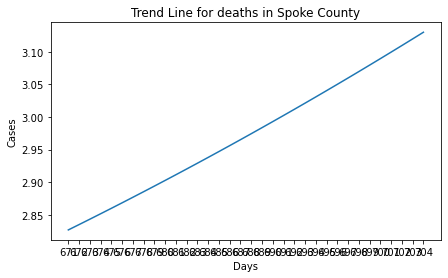

In [195]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_s)
plt.title('Trend Line for deaths in Spoke County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_s, pred_spoke3)

Confidence Interval

In [196]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [197]:
up = []
low = []
for i in range(len(X_test_s)):
    up.append(get_prediction_interval(i,y_test_s2, pred_spoke2)[2])
    low.append(get_prediction_interval(i,y_test_s2, pred_spoke2)[0])

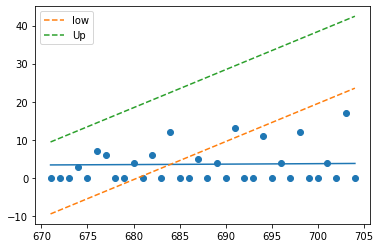

In [198]:
plt.scatter(X_test_s,y_test_s2)
plt.plot(X_test_s,pred_spoke2)
plt.plot(X_test_s,low,'--',label='low')
plt.plot(X_test_s,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

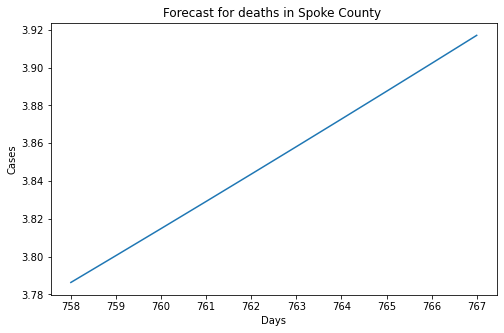

In [199]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for deaths in Spoke County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next,pl_spoke_deaths.predict(next.reshape(-1, 1)))

***Snohomish County***

In [200]:
sno_cnty = snoho_cnty.reset_index()
sno_cnty

Date   Cases  Death
0   2020-01-22       0      0
1   2020-01-23       0      0
2   2020-01-24       0      0
3   2020-01-25       0      0
4   2020-01-26       0      0
..         ...     ...    ...
753 2022-02-13  148223   1000
754 2022-02-14  146353   1007
755 2022-02-15  146353   1007
756 2022-02-16  145854   1019
757 2022-02-17  145854   1019

[758 rows x 3 columns]

In [201]:
c = 1
for i in sno_cnty['Cases'].values:
    if i > 0:
        print(c)
        break
    c = c + 1

39


In [202]:
#new cases
snoho_cnty['New cases'] = snoho_cnty['Cases'].diff()
#new Deaths
snoho_cnty['New deaths'] = snoho_cnty['Death'].diff()
snoho_cnty = snoho_cnty[1:]
snoho_cnty = snoho_cnty.reset_index()
snoho_cnty

Date   Cases  Death  New cases  New deaths
0   2020-01-23       0      0        0.0         0.0
1   2020-01-24       0      0        0.0         0.0
2   2020-01-25       0      0        0.0         0.0
3   2020-01-26       0      0        0.0         0.0
4   2020-01-27       0      0        0.0         0.0
..         ...     ...    ...        ...         ...
752 2022-02-13  148223   1000        0.0         0.0
753 2022-02-14  146353   1007    -1870.0         7.0
754 2022-02-15  146353   1007        0.0         0.0
755 2022-02-16  145854   1019     -499.0        12.0
756 2022-02-17  145854   1019        0.0         0.0

[757 rows x 5 columns]

In [203]:
snoho_cnty['Day_count'] = [x for x in range(1,len(snoho_cnty)+1)]
snoho_cnty

Date   Cases  Death  New cases  New deaths  Day_count
0   2020-01-23       0      0        0.0         0.0          1
1   2020-01-24       0      0        0.0         0.0          2
2   2020-01-25       0      0        0.0         0.0          3
3   2020-01-26       0      0        0.0         0.0          4
4   2020-01-27       0      0        0.0         0.0          5
..         ...     ...    ...        ...         ...        ...
752 2022-02-13  148223   1000        0.0         0.0        753
753 2022-02-14  146353   1007    -1870.0         7.0        754
754 2022-02-15  146353   1007        0.0         0.0        755
755 2022-02-16  145854   1019     -499.0        12.0        756
756 2022-02-17  145854   1019        0.0         0.0        757

[757 rows x 6 columns]

In [204]:
# Removing Negative values from New cases and New deaths
def rem_neg(a):
    if a <= 0:
        return 0
    else:
        return a

In [205]:
snoho_cnty['New cases'] = snoho_cnty['New cases'].apply(rem_neg)
snoho_cnty['New deaths'] = snoho_cnty['New deaths'].apply(rem_neg)

In [206]:
snoho_cnty1 = snoho_cnty[38:]
snoho_cnty1

Date   Cases  Death  New cases  New deaths  Day_count
38  2020-03-01       2      0        1.0         0.0         39
39  2020-03-02       4      1        2.0         1.0         40
40  2020-03-03       6      1        2.0         0.0         41
41  2020-03-04       8      1        2.0         0.0         42
42  2020-03-05      18      1       10.0         0.0         43
..         ...     ...    ...        ...         ...        ...
752 2022-02-13  148223   1000        0.0         0.0        753
753 2022-02-14  146353   1007        0.0         7.0        754
754 2022-02-15  146353   1007        0.0         0.0        755
755 2022-02-16  145854   1019        0.0        12.0        756
756 2022-02-17  145854   1019        0.0         0.0        757

[719 rows x 6 columns]

Seprating Snohomish County Data into Test and Training data

In [207]:
#Training Data
X_train_sno = snoho_cnty1['Day_count'][:690]
y_train_sno1 = snoho_cnty1['New cases'][:690] #sno1 = new cases in snohomish county
y_train_sno2 = snoho_cnty1['New deaths'][:690] #sno2 = new deaths in snohomish county

#Test Data
X_test_sno = snoho_cnty1['Day_count'][690:]
y_test_sno1 = snoho_cnty1['New cases'][690:]
y_test_sno2 = snoho_cnty1['New deaths'][690:]

In [208]:
#Reshaping the data
X_train_sno = np.array(X_train_sno).reshape(-1,1)
y_train_sno1 = np.array(y_train_sno1).reshape(-1,1)
y_train_sno2 = np.array(y_train_sno2).reshape(-1,1)

X_test_sno = np.array(X_test_sno).reshape(-1,1)
y_test_sno1 = np.array(y_test_sno1).reshape(-1,1)
y_test_sno2 = np.array(y_test_sno2).reshape(-1,1)

**Linear Regression**

In [209]:
lr = LinearRegression()
lr.fit(X_train_sno,y_train_sno1)

LinearRegression()

In [210]:
lr_pred_test_sno1 = lr.predict(X_test_sno)
lr_pred_test_sno1

array([[393.35562988],
       [394.02043151],
       [394.68523314],
       [395.35003477],
       [396.0148364 ],
       [396.67963803],
       [397.34443966],
       [398.00924129],
       [398.67404292],
       [399.33884455],
       [400.00364618],
       [400.66844781],
       [401.33324944],
       [401.99805107],
       [402.6628527 ],
       [403.32765433],
       [403.99245596],
       [404.65725759],
       [405.32205922],
       [405.98686085],
       [406.65166248],
       [407.31646411],
       [407.98126574],
       [408.64606737],
       [409.310869  ],
       [409.97567063],
       [410.64047226],
       [411.30527389],
       [411.97007552]])

Calculating RMSE for Snohomish County Cases

In [211]:
mse_snoho_cases = np.square(np.subtract(y_test_sno1, lr_pred_test_sno1)).mean()
rmse_snoho_cases = math.sqrt(mse_snoho_cases)
rmse_snoho_cases

2314.7505876357022

Polynomial Regression For new cases in Snohomish County with degree 2

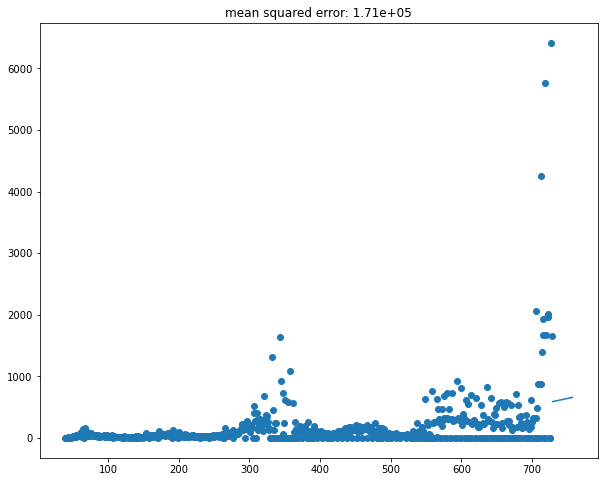

In [212]:
# polynomial regression for degree 2
pl_snoho_cases = PolynomialRegression(2)
pl_snoho_cases.fit(X_train_sno, y_train_sno1)
pred_snoho = pl_snoho_cases.predict(X_test_sno)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_sno.ravel(), y_train_sno1)
plt.plot(X_test_sno.ravel(),pred_snoho)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_snoho_cases.predict(X_train_sno), y_train_sno1)));


RMSE for new Cases in Snohomish county for degree 2

In [213]:
mse_snoho_casespy = np.square(np.subtract(y_test_sno1, pred_snoho)).mean()
rmse_snoho_casespy = math.sqrt(mse_snoho_casespy)
rmse_snoho_casespy

2247.9111928580105

Polynomial Regression For new cases in Snohomish County with degree 3

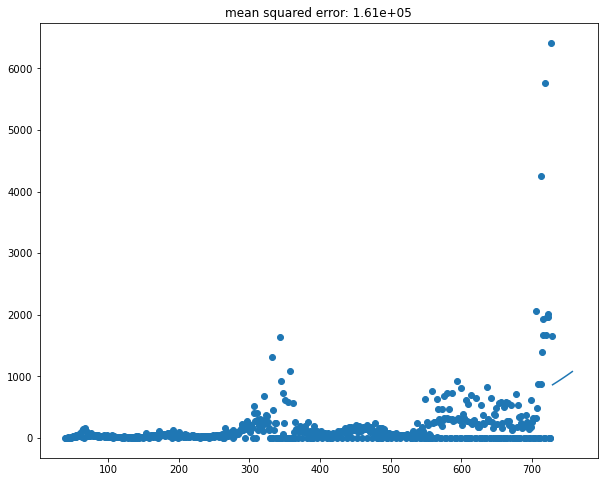

In [214]:
# polynomial regression for degree 3
pl_snoho_cases = PolynomialRegression(3)
pl_snoho_cases.fit(X_train_sno, y_train_sno1)
pred_snoho = pl_snoho_cases.predict(X_test_sno)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_sno.ravel(), y_train_sno1)
plt.plot(X_test_sno.ravel(),pred_snoho)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_snoho_cases.predict(X_train_sno), y_train_sno1)));

In [215]:
mse_snoho_casespy = np.square(np.subtract(y_test_sno1, pred_snoho)).mean()
rmse_snoho_casespy = math.sqrt(mse_snoho_casespy)
rmse_snoho_casespy

2193.5777739108257

***Trend Line for Cases in Snohomish county***

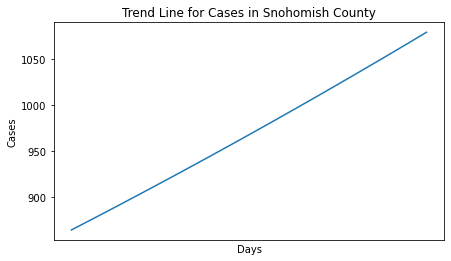

In [216]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_p)
plt.title('Trend Line for Cases in Snohomish County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_sno, pred_snoho)

Confidence Interval

In [217]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [218]:
up = []
low = []
for i in range(len(X_test_sno)):
    up.append(get_prediction_interval(i,y_test_sno1, pred_snoho)[2])
    low.append(get_prediction_interval(i,y_test_sno1, pred_snoho)[0])

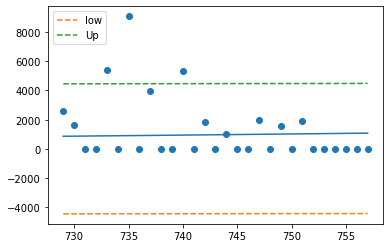

In [219]:
plt.scatter(X_test_sno,y_test_sno1)
plt.plot(X_test_sno,pred_snoho)
plt.plot(X_test_sno,low,'--',label='low')
plt.plot(X_test_sno,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

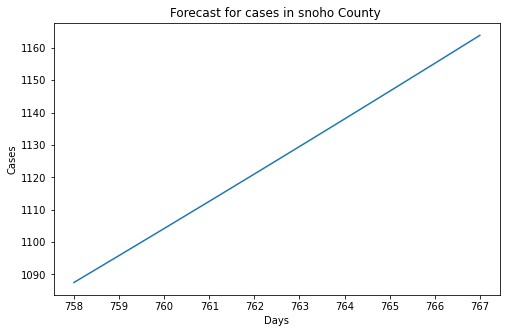

In [220]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for cases in snoho County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next,pl_snoho_cases.predict(next.reshape(-1, 1)))

Linear Regression for deaths in Snohomish County

In [221]:
lr = LinearRegression()
lr.fit(X_train_sno,y_train_sno2)

LinearRegression()

In [222]:
#predicting the data
lr_pred_test_sno2 = lr.predict(X_test_sno)
lr_pred_test_sno2

array([[1.37596601],
       [1.37610199],
       [1.37623796],
       [1.37637394],
       [1.37650992],
       [1.3766459 ],
       [1.37678188],
       [1.37691786],
       [1.37705383],
       [1.37718981],
       [1.37732579],
       [1.37746177],
       [1.37759775],
       [1.37773373],
       [1.3778697 ],
       [1.37800568],
       [1.37814166],
       [1.37827764],
       [1.37841362],
       [1.3785496 ],
       [1.37868557],
       [1.37882155],
       [1.37895753],
       [1.37909351],
       [1.37922949],
       [1.37936547],
       [1.37950144],
       [1.37963742],
       [1.3797734 ]])

Calculating the MSE for deaths

In [223]:
mse_snoho_deaths = np.square(np.subtract(y_test_sno2, lr_pred_test_sno2)).mean()
rmse_snoho_deaths = math.sqrt(mse_snoho_deaths)
rmse_snoho_deaths

7.046101828541906

Polynomial Regression for degree 2 

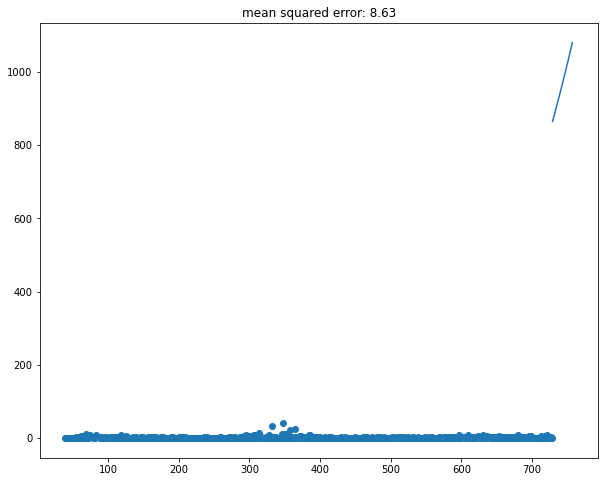

In [224]:
# polynomial regression for degree 2
pl_snoho_deaths = PolynomialRegression(2)
pl_snoho_deaths.fit(X_train_sno, y_train_sno2)
pred_snoho2 = pl_snoho_deaths.predict(X_test_sno)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_sno.ravel(), y_train_sno2)
plt.plot(X_test_sno.ravel(),pred_snoho)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_snoho_deaths.predict(X_train_sno), y_train_sno2)));


RMSE for deaths in Snohomish county with degree 2

In [225]:
mse_snoho_deathspy = np.square(np.subtract(y_test_sno2, pred_snoho2)).mean()
rmse_snoho_deathspy = math.sqrt(mse_snoho_deathspy)
rmse_snoho_deathspy

7.029219902481668

Polynomial regression for degree 3

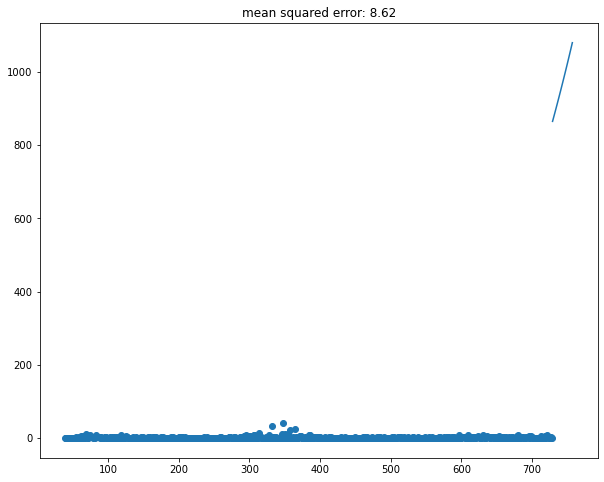

In [226]:
# polynomial regression for degree 3
pl_snoho_deaths = PolynomialRegression(3)
pl_snoho_deaths.fit(X_train_sno, y_train_sno2)
pred_snoho3 = pl_snoho_deaths.predict(X_test_sno)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_sno.ravel(), y_train_sno2)
plt.plot(X_test_sno.ravel(),pred_snoho)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_snoho_deaths.predict(X_train_sno), y_train_sno2)));

Calculating The RMSE for deaths in Snohomish county for degree 3

In [227]:
mse_snoho_deathspy = np.square(np.subtract(y_test_sno2, pred_snoho3)).mean()
rmse_snoho_deathspy = math.sqrt(mse_snoho_deathspy)
rmse_snoho_deathspy

6.871938607328265

***Trend Line for Deaths in snohomish county***

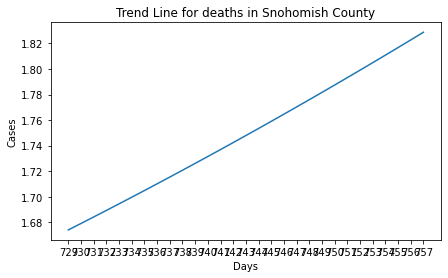

In [228]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_sno)
plt.title('Trend Line for deaths in Snohomish County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_sno, pred_snoho3)

Confidence Interval

In [229]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [230]:
up = []
low = []
for i in range(len(X_test_sno)):
    up.append(get_prediction_interval(i,y_test_sno2, pred_snoho3)[2])
    low.append(get_prediction_interval(i,y_test_sno2, pred_snoho3)[0])

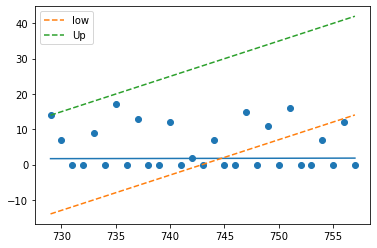

In [231]:
plt.scatter(X_test_sno,y_test_sno2)
plt.plot(X_test_sno,pred_snoho3)
plt.plot(X_test_sno,low,'--',label='low')
plt.plot(X_test_sno,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

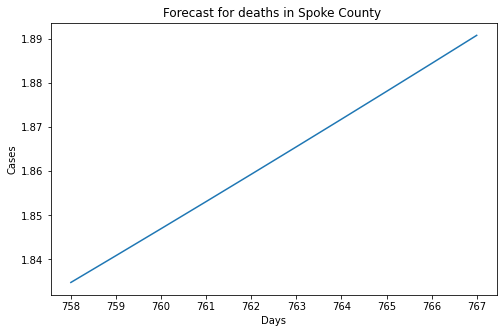

In [232]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for deaths in Spoke County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next,pl_snoho_deaths.predict(next.reshape(-1, 1)))

***yakima County***

In [233]:
y_cnty = yakima_cnty.reset_index()
y_cnty

Date  Cases  Death
0   2020-01-22      0      0
1   2020-01-23      0      0
2   2020-01-24      0      0
3   2020-01-25      0      0
4   2020-01-26      0      0
..         ...    ...    ...
753 2022-02-13  70581    720
754 2022-02-14  70384    725
755 2022-02-15  70384    725
756 2022-02-16  70390    731
757 2022-02-17  70390    731

[758 rows x 3 columns]

In [234]:
c = 1
for i in y_cnty['Cases'].values:
    if i > 0:
        print(c)
        break
    c = c + 1

52


In [235]:
#new cases
yakima_cnty['New cases'] = yakima_cnty['Cases'].diff()
#new Deaths
yakima_cnty['New deaths'] = yakima_cnty['Death'].diff()
yakima_cnty = yakima_cnty[1:]
yakima_cnty = yakima_cnty.reset_index()
yakima_cnty

Date  Cases  Death  New cases  New deaths
0   2020-01-23      0      0        0.0         0.0
1   2020-01-24      0      0        0.0         0.0
2   2020-01-25      0      0        0.0         0.0
3   2020-01-26      0      0        0.0         0.0
4   2020-01-27      0      0        0.0         0.0
..         ...    ...    ...        ...         ...
752 2022-02-13  70581    720        0.0         0.0
753 2022-02-14  70384    725     -197.0         5.0
754 2022-02-15  70384    725        0.0         0.0
755 2022-02-16  70390    731        6.0         6.0
756 2022-02-17  70390    731        0.0         0.0

[757 rows x 5 columns]

In [236]:
# Removing Negative values from New cases and New deaths
def rem_neg(a):
    if a <= 0:
        return 0
    else:
        return a


In [237]:
yakima_cnty['New cases'] = yakima_cnty['New cases'].apply(rem_neg)
yakima_cnty['New deaths'] = yakima_cnty['New deaths'].apply(rem_neg)

In [238]:
yakima_cnty['Day_count'] = [x for x in range(1,len(yakima_cnty)+1)]
yakima_cnty

Date  Cases  Death  New cases  New deaths  Day_count
0   2020-01-23      0      0        0.0         0.0          1
1   2020-01-24      0      0        0.0         0.0          2
2   2020-01-25      0      0        0.0         0.0          3
3   2020-01-26      0      0        0.0         0.0          4
4   2020-01-27      0      0        0.0         0.0          5
..         ...    ...    ...        ...         ...        ...
752 2022-02-13  70581    720        0.0         0.0        753
753 2022-02-14  70384    725        0.0         5.0        754
754 2022-02-15  70384    725        0.0         0.0        755
755 2022-02-16  70390    731        6.0         6.0        756
756 2022-02-17  70390    731        0.0         0.0        757

[757 rows x 6 columns]

In [239]:
yak_cnty = yakima_cnty[52:]
yak_cnty

Date  Cases  Death  New cases  New deaths  Day_count
52  2020-03-15      4      0        0.0         0.0         53
53  2020-03-16      4      0        0.0         0.0         54
54  2020-03-17      5      0        1.0         0.0         55
55  2020-03-18      7      0        2.0         0.0         56
56  2020-03-19      7      0        0.0         0.0         57
..         ...    ...    ...        ...         ...        ...
752 2022-02-13  70581    720        0.0         0.0        753
753 2022-02-14  70384    725        0.0         5.0        754
754 2022-02-15  70384    725        0.0         0.0        755
755 2022-02-16  70390    731        6.0         6.0        756
756 2022-02-17  70390    731        0.0         0.0        757

[705 rows x 6 columns]

Seprating Yakima County Data into Test and Training data

In [240]:
#Training Data
X_train_y = yak_cnty['Day_count'][:690]
y_train_y1 = yak_cnty['New cases'][:690] #y1 = new cases in Yakima county
y_train_y2 = yak_cnty['New deaths'][:690] #y2 = new deaths in Yakima county

#Test Data
X_test_y = yak_cnty['Day_count'][690:]
y_test_y1 = yak_cnty['New cases'][690:]
y_test_y2 = yak_cnty['New deaths'][690:]

In [241]:
#Reshaping the data
X_train_y = np.array(X_train_y).reshape(-1,1)
y_train_y1 = np.array(y_train_y1).reshape(-1,1)
y_train_y2 = np.array(y_train_y2).reshape(-1,1)

X_test_y = np.array(X_test_y).reshape(-1,1)
y_test_y1 = np.array(y_test_y1).reshape(-1,1)
y_test_y2 = np.array(y_test_y2).reshape(-1,1)

In [242]:
lr = LinearRegression()
lr.fit(X_train_y,y_train_y1)

LinearRegression()

In [243]:
lr_pred_test_y1 = lr.predict(X_test_y)
lr_pred_test_y1

array([[190.0879788 ],
       [190.3475174 ],
       [190.607056  ],
       [190.86659461],
       [191.12613321],
       [191.38567181],
       [191.64521042],
       [191.90474902],
       [192.16428762],
       [192.42382623],
       [192.68336483],
       [192.94290344],
       [193.20244204],
       [193.46198064],
       [193.72151925]])

Calculating RMSE for Snohomish County Cases

In [244]:
mse_yak_cases = np.square(np.subtract(y_test_y1, lr_pred_test_y1)).mean()
rmse_yak_cases = math.sqrt(mse_yak_cases)
rmse_yak_cases

319.87769914474677

***Trend Line for Cases in Yakima county***

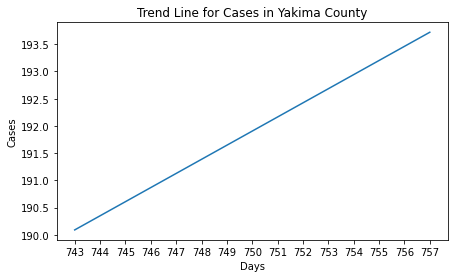

In [245]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_y)
plt.title('Trend Line for Cases in Yakima County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_y, lr_pred_test_y1 )

Confidence Interval

In [246]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [247]:
up = []
low = []
for i in range(len(X_test_y)):
    up.append(get_prediction_interval(i,y_test_y1, lr_pred_test_y1)[2])
    low.append(get_prediction_interval(i,y_test_y1, lr_pred_test_y1)[0])

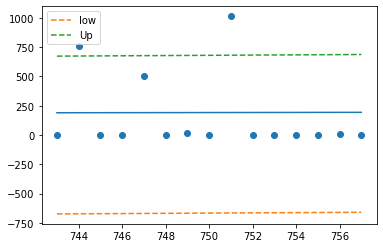

In [248]:
plt.scatter(X_test_y,y_test_y1)
plt.plot(X_test_y,lr_pred_test_y1)
plt.plot(X_test_y,low,'--',label='low')
plt.plot(X_test_y,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

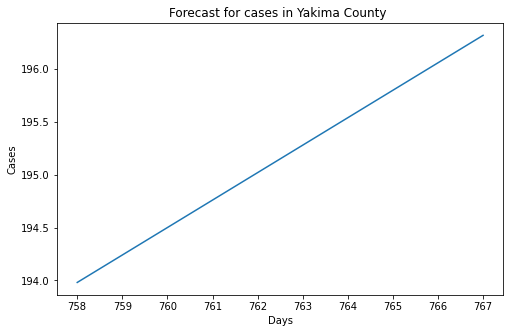

In [249]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for cases in Yakima County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next,lr.predict(next.reshape(-1, 1)))

Polynomial Regression For new cases in Yakima County with degree 2

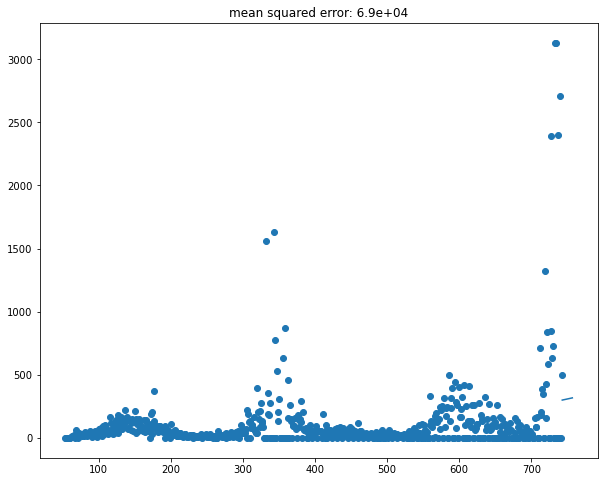

In [250]:
# polynomial regression for degree 2
pl_yak_cases = PolynomialRegression(2)
pl_yak_cases.fit(X_train_y, y_train_y1)
pred_yak = pl_yak_cases.predict(X_test_y)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_y.ravel(), y_train_y1)
plt.plot(X_test_y.ravel(),pred_yak)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_yak_cases.predict(X_train_y), y_train_y1)));


RMSE for new Cases in Yakima county for degree 2

In [251]:
mse_yak_casespy = np.square(np.subtract(y_test_y1, pred_yak)).mean()
rmse_yak_casespy = math.sqrt(mse_yak_casespy)
rmse_yak_casespy

354.76547820319365

Polynomial Regression For new cases in Yakima County with degree 3

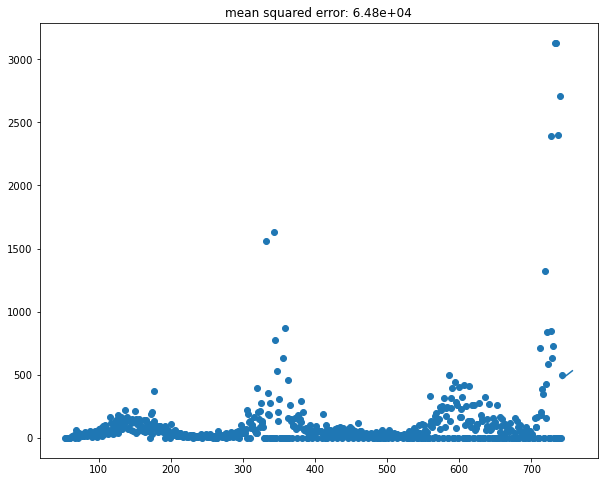

In [252]:
# polynomial regression for degree 3
pl_yak_cases = PolynomialRegression(3)
pl_yak_cases.fit(X_train_y, y_train_y1)
pred_yak = pl_yak_cases.predict(X_test_y)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_y.ravel(), y_train_y1)
plt.plot(X_test_y.ravel(),pred_yak)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_yak_cases.predict(X_train_y), y_train_y1)));

In [253]:
mse_yak_casespy = np.square(np.subtract(y_test_y1, pred_yak)).mean()
rmse_yak_casespy = math.sqrt(mse_yak_casespy)
rmse_yak_casespy

474.7196505134804

Linear Regression for deaths in Yakima County

In [254]:
lr = LinearRegression()
lr.fit(X_train_y,y_train_y2)

LinearRegression()

In [255]:
#predicting the data
lr_pred_test_y2 = lr.predict(X_test_y)
lr_pred_test_y2

array([[0.86781936],
       [0.86728996],
       [0.86676057],
       [0.86623118],
       [0.86570178],
       [0.86517239],
       [0.864643  ],
       [0.8641136 ],
       [0.86358421],
       [0.86305482],
       [0.86252543],
       [0.86199603],
       [0.86146664],
       [0.86093725],
       [0.86040785]])

Calculating the MSE for deaths

In [256]:
mse_yak_deaths = np.square(np.subtract(y_test_y2, lr_pred_test_y2)).mean()
rmse_yak_deaths = math.sqrt(mse_yak_deaths)
rmse_yak_deaths

4.495270696247263

Polynomial Regression for degree 2 

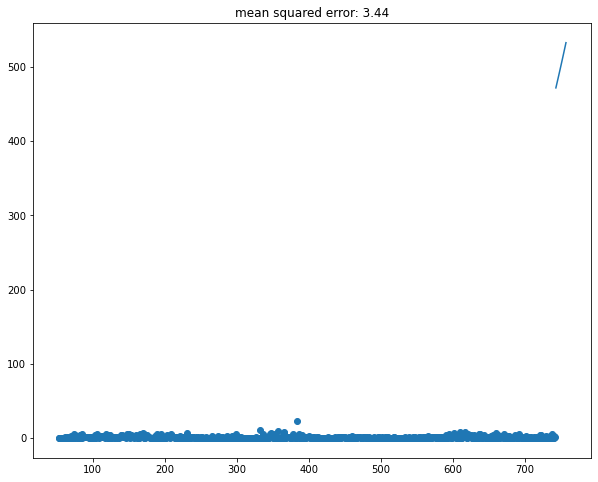

In [257]:
# polynomial regression for degree 2
pl_yak_deaths = PolynomialRegression(2)
pl_yak_deaths.fit(X_train_y, y_train_y2)
pred_yak2 = pl_yak_deaths.predict(X_test_y)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_y.ravel(), y_train_y2)
plt.plot(X_test_y.ravel(),pred_yak)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_yak_deaths.predict(X_train_y), y_train_y2)));


RMSE for deaths in Yakima county with degree 2

In [258]:
mse_yak_deathspy = np.square(np.subtract(y_test_y2, pred_yak2)).mean()
rmse_yak_deathspy = math.sqrt(mse_yak_deathspy)
rmse_yak_deathspy

4.330661823061963

Polynomial regression for degree 3

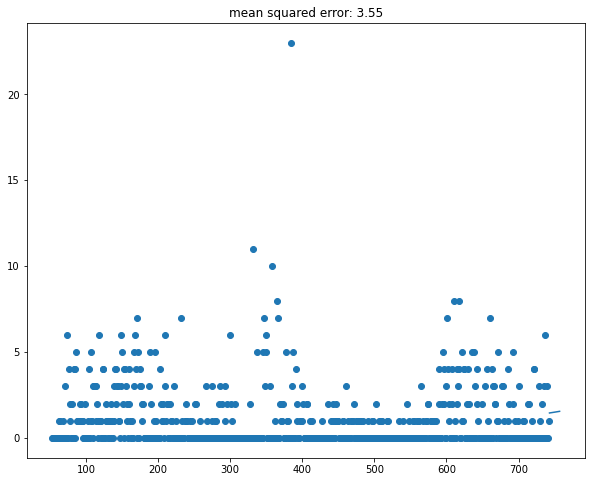

In [259]:
# polynomial regression for degree 3
pl_yak_deaths = PolynomialRegression(3)
pl_yak_deaths.fit(X_train_y, y_train_y2)
pred_yak3 = pl_yak_deaths.predict(X_test_y)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(X_train_y.ravel(), y_train_y2)
plt.plot(X_test_y.ravel(),pred_yak3)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(pl_snoho_deaths.predict(X_train_y), y_train_y2)));

Calculating The RMSE for deaths in Yakima county for degree 3

In [260]:
mse_yak_deathspy = np.square(np.subtract(y_test_y2, pred_yak3)).mean()
rmse_yak_deathspy = math.sqrt(mse_yak_deathspy)
rmse_yak_deathspy

4.243718530996534

***Trend Line for Deaths in yakima county***

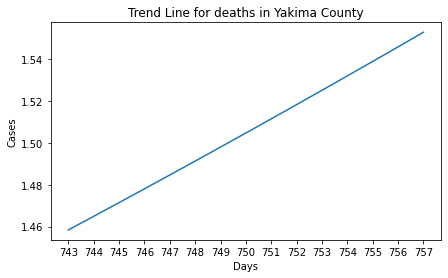

In [261]:
plt.figure(figsize=(7,4))
plt.xticks(X_test_sno)
plt.title('Trend Line for deaths in Yakima County')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(X_test_y, pred_yak3)

Confidence Interval

In [262]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    
#get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
#generate prediction interval lower and upper bound cs_24
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

In [263]:
up = []
low = []
for i in range(len(X_test_y)):
    up.append(get_prediction_interval(i,y_test_y2, pred_yak3)[2])
    low.append(get_prediction_interval(i,y_test_y2, pred_yak3)[0])

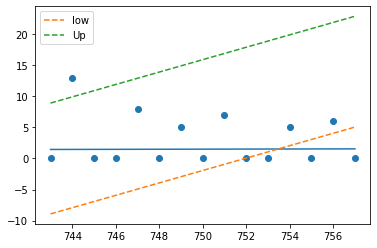

In [264]:
plt.scatter(X_test_y,y_test_y2)
plt.plot(X_test_y,pred_yak3)
plt.plot(X_test_y,low,'--',label='low')
plt.plot(X_test_y,up,'--',label='Up')
plt.legend(loc='upper left')

***Forecast***

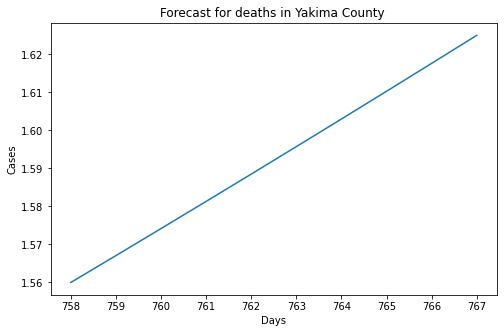

In [265]:
next = np.arange(758,768)
plt.figure(figsize=(8,5))
plt.xticks(next)
plt.title('Forecast for deaths in Yakima County ')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.plot(next,pl_yak_deaths.predict(next.reshape(-1, 1)))

Hypothesis Test

In [ ]:
covid['County Name'] = covid['County Name'].str.rstrip()
covid['New cases'] = covid['Cases'].diff()
covid['New deaths'] = covid['Death'].diff()
covid.head()

In [ ]:
poll = pd.read_csv("../../../data/member/akash/pres_merged_final.csv")
poll.drop(labels='Unnamed: 0',axis=1,inplace=True)
poll.drop(labels=['state', 'percent'], axis=1, inplace= True)
poll.rename(columns = {'county' : 'County Name'}, inplace = True)
poll.head()

In [ ]:
merged = pd.merge (poll[:75000], covid[:75000], on = ['County Name'])
merged = merged.drop(0)
merged.head()

***1. Does the number of votes depend on the Cases of each County***

In [ ]:
res = stats.ttest_ind(merged['Cases'], merged['current_votes'], equal_var = False)
display(res)

Here the P value is astronomically less hence the T test returns the P value as 0 which is less than 0.05 which we can assume The hypothesis has failed

***2.The States with Higher populations have higher Voting Rates***

In [ ]:
res = stats.ttest_ind(merged['total_votes'], merged['population'], equal_var = False)
display(res)

the T test returns the P value as 0 which is less than 0.05 which we can assume The hypothesis has failed